## Usando Machine Learning para detectar logos em imagens
***

Histograma de Gradientes Orientados, ou HOG para abreviar, são descritores usados principalmente em visão computacional e na aprendizagem de máquinas para a detecção de objetos. No entanto, também podemos usar os descritores HOG para quantificar e representar a forma e a textura.

Na maioria dos aplicativos do mundo real, HOG é usado em conjunto com um SVM linear para realizar a detecção de objetos. A razão pela qual o HOG é utilizado tão fortemente é porque a aparência e a forma do objeto local podem ser caracterizados usando a distribuição de gradientes de intensidade locais.

Na verdade, estes são exatamente os mesmos gradientes de imagem que aprendemos no capítulo anterior, mas agora agora vamos levar esses gradientes de imagem e transformá-los em um descritor de imagem robusto e poderoso.

Os descritores HOG são usados principalmente para descrever a forma estrutural e a aparência de um objeto em uma imagem, tornando-os excelentes descritores para classificação de objetos. No entanto, uma vez que o HOG captura gradientes de intensidade local e direções de borda, também se torna um bom descritor de textura.

HOG é implementado em OpenCV e scikit-image. A implementação OpenCV é menos flexível do que a implementação scikit e, portanto, usaremos principalmente a implementação do scikit aqui.

HOG são os recursos que são extraidos da nossa imagem.

***

In [1]:
# Imports
import imutils
import cv2
from sklearn.neighbors import KNeighborsClassifier
from skimage import exposure
from skimage import feature
from imutils import paths
from matplotlib import pyplot as plt


def show(img, title=""):
    """
    Redimensionar a imagem e mostrar no codigo.
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.title(title, fontdict={"fontsize": 100})
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [2]:
# Inicializa a matriz de dados e de labels
data = []
labels = []

In [3]:
# Loop pelas imagens no dataset de treino
for imagePath in paths.list_images("imagens/dataset04/car_logos"):
    make = imagePath.split("/")[-2]
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = imutils.auto_canny(gray)

    # Encontra contornos no mapa de borda, mantendo apenas o maior que se supõe ser o logotipo do carro
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)

    # Extrai o logotipo do carro e redimensiona 
    (x, y, w, h) = cv2.boundingRect(c)
    logo = gray[y:y + h, x:x + w]
    logo = cv2.resize(logo, (200, 100))

    # Extrai Histograma de Gradientes Orientados do logotipo
    # Os parâmetros mais importantes para o descritor HOG são: orientations, pixels_per_cell e cells_per_block. 
    # Esses três parâmetros (juntamente com o tamanho da imagem de entrada) controlam efetivamente
    # a dimensionalidade do vetor de características resultante.
    H = feature.hog(logo, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True)

    # Atualiza dados e labels
    data.append(H)
    labels.append(make)

In [4]:
# Cria a modelo e Treina o Classificador Nearest Neighbors
model = KNeighborsClassifier(n_neighbors=1)
model.fit(data, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

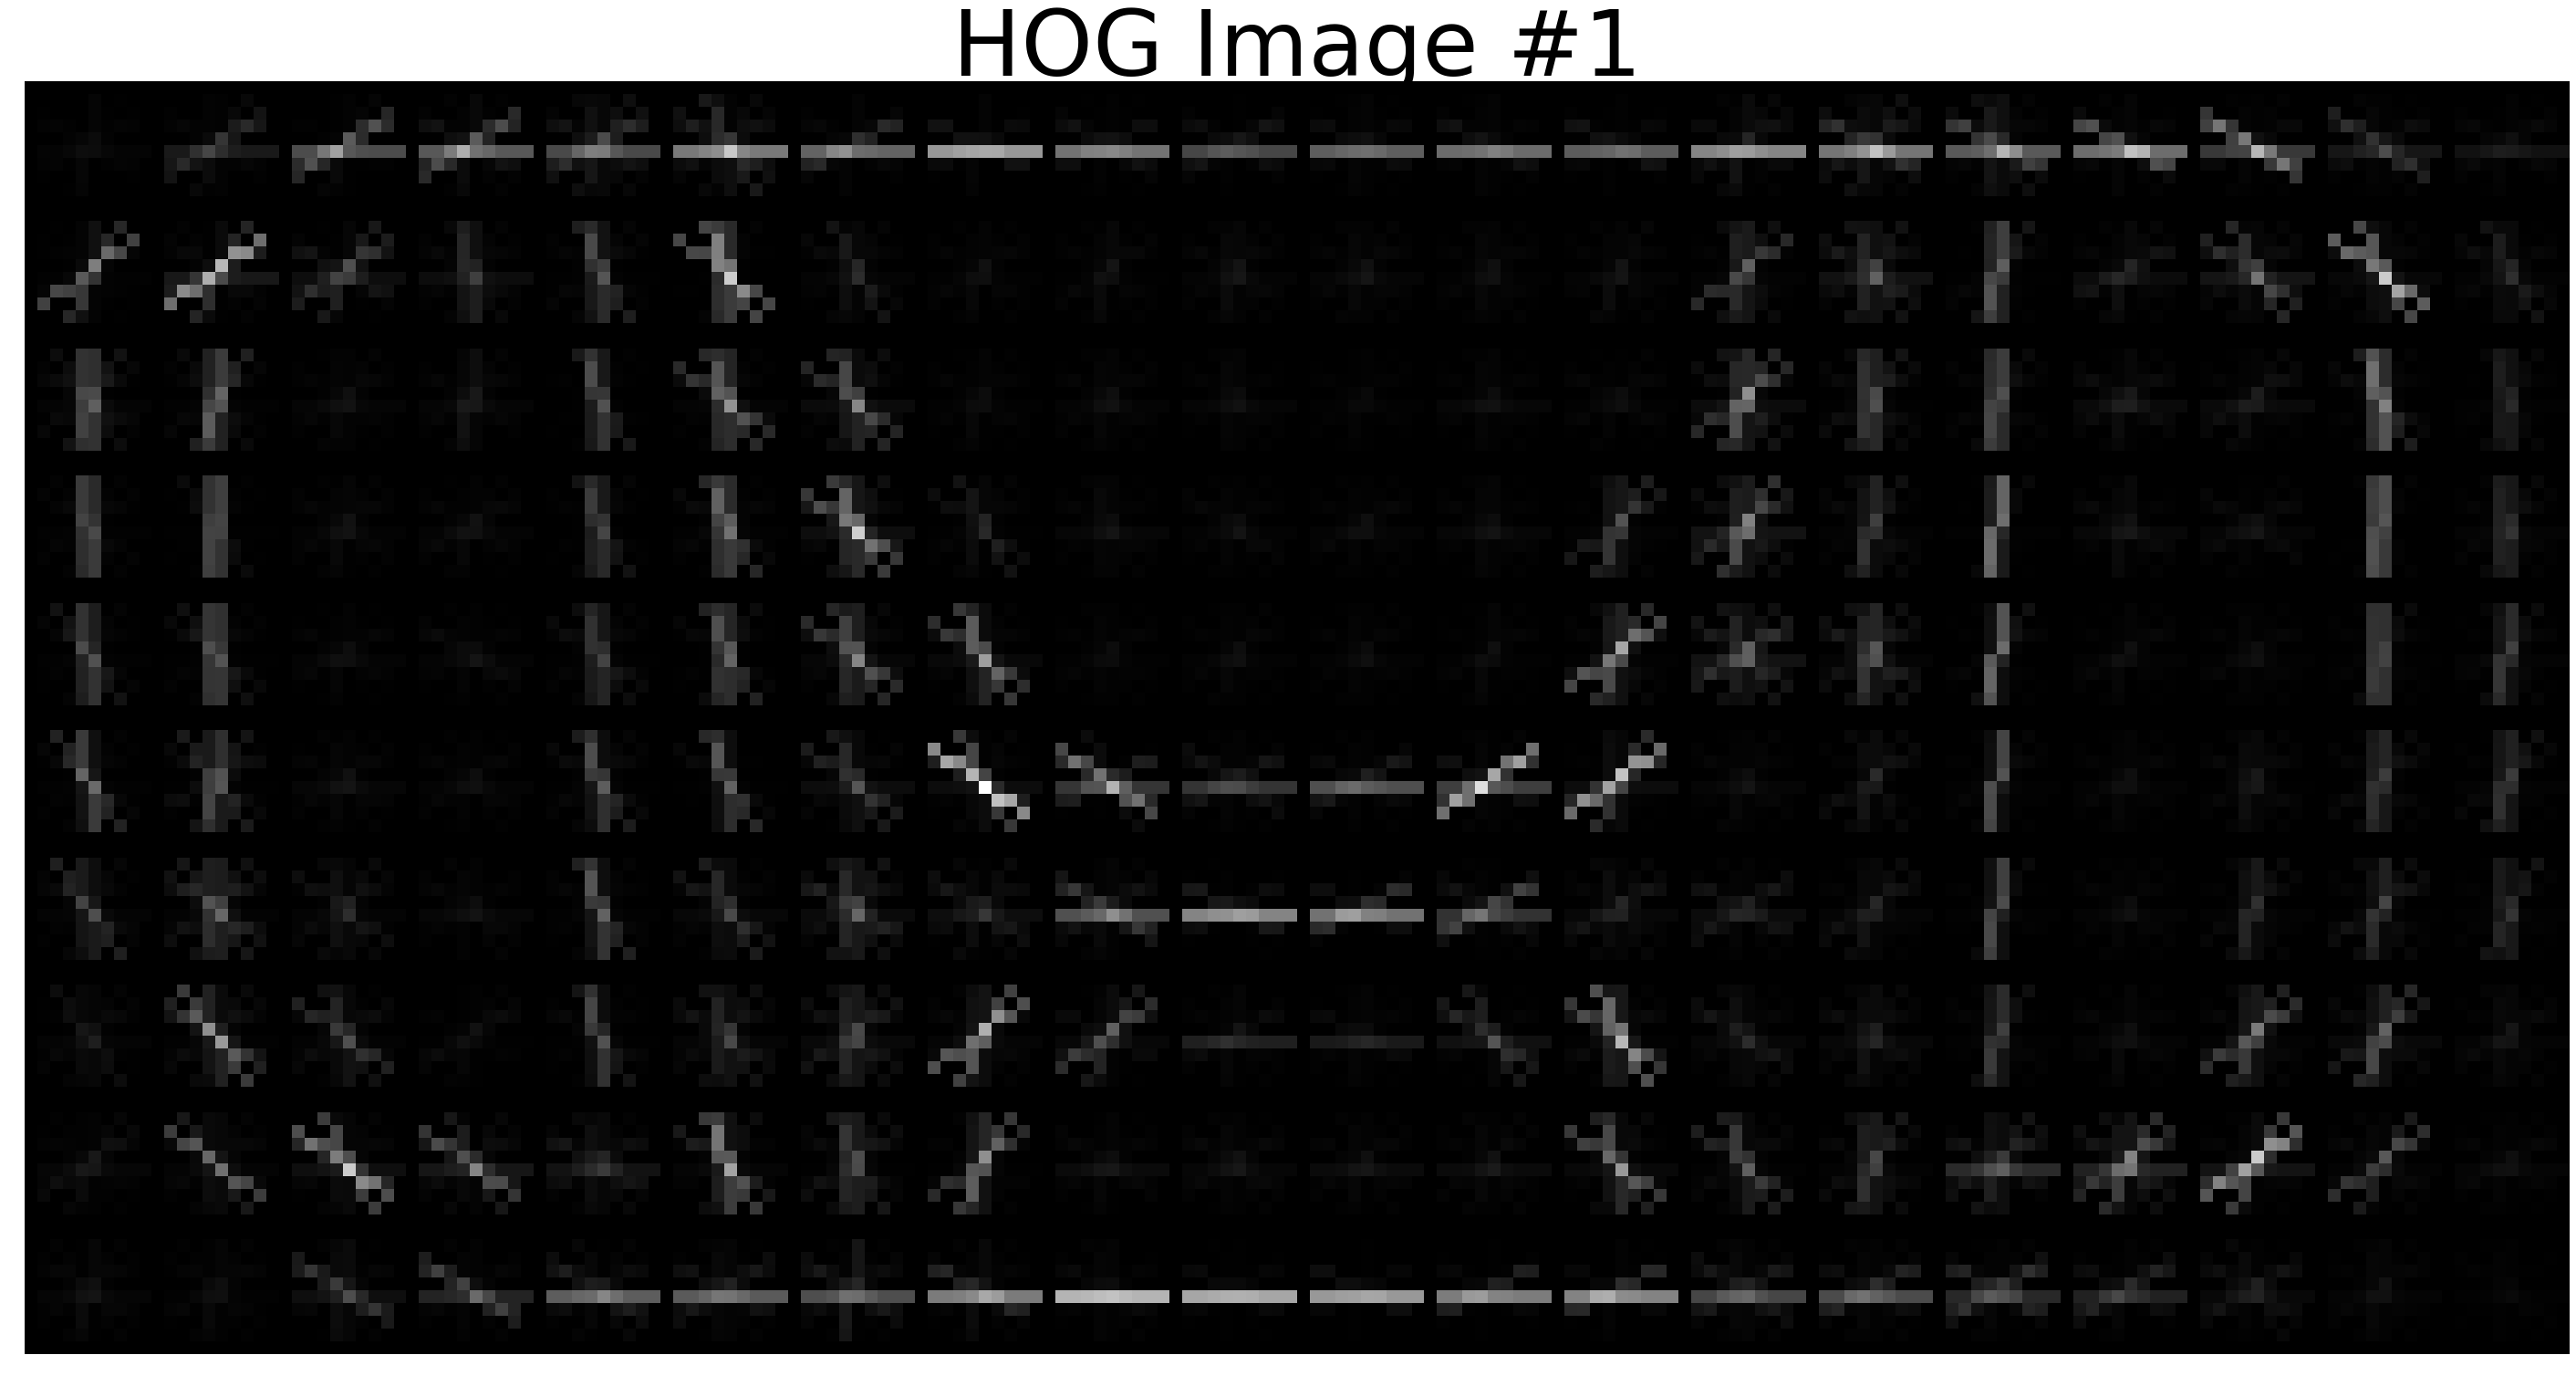

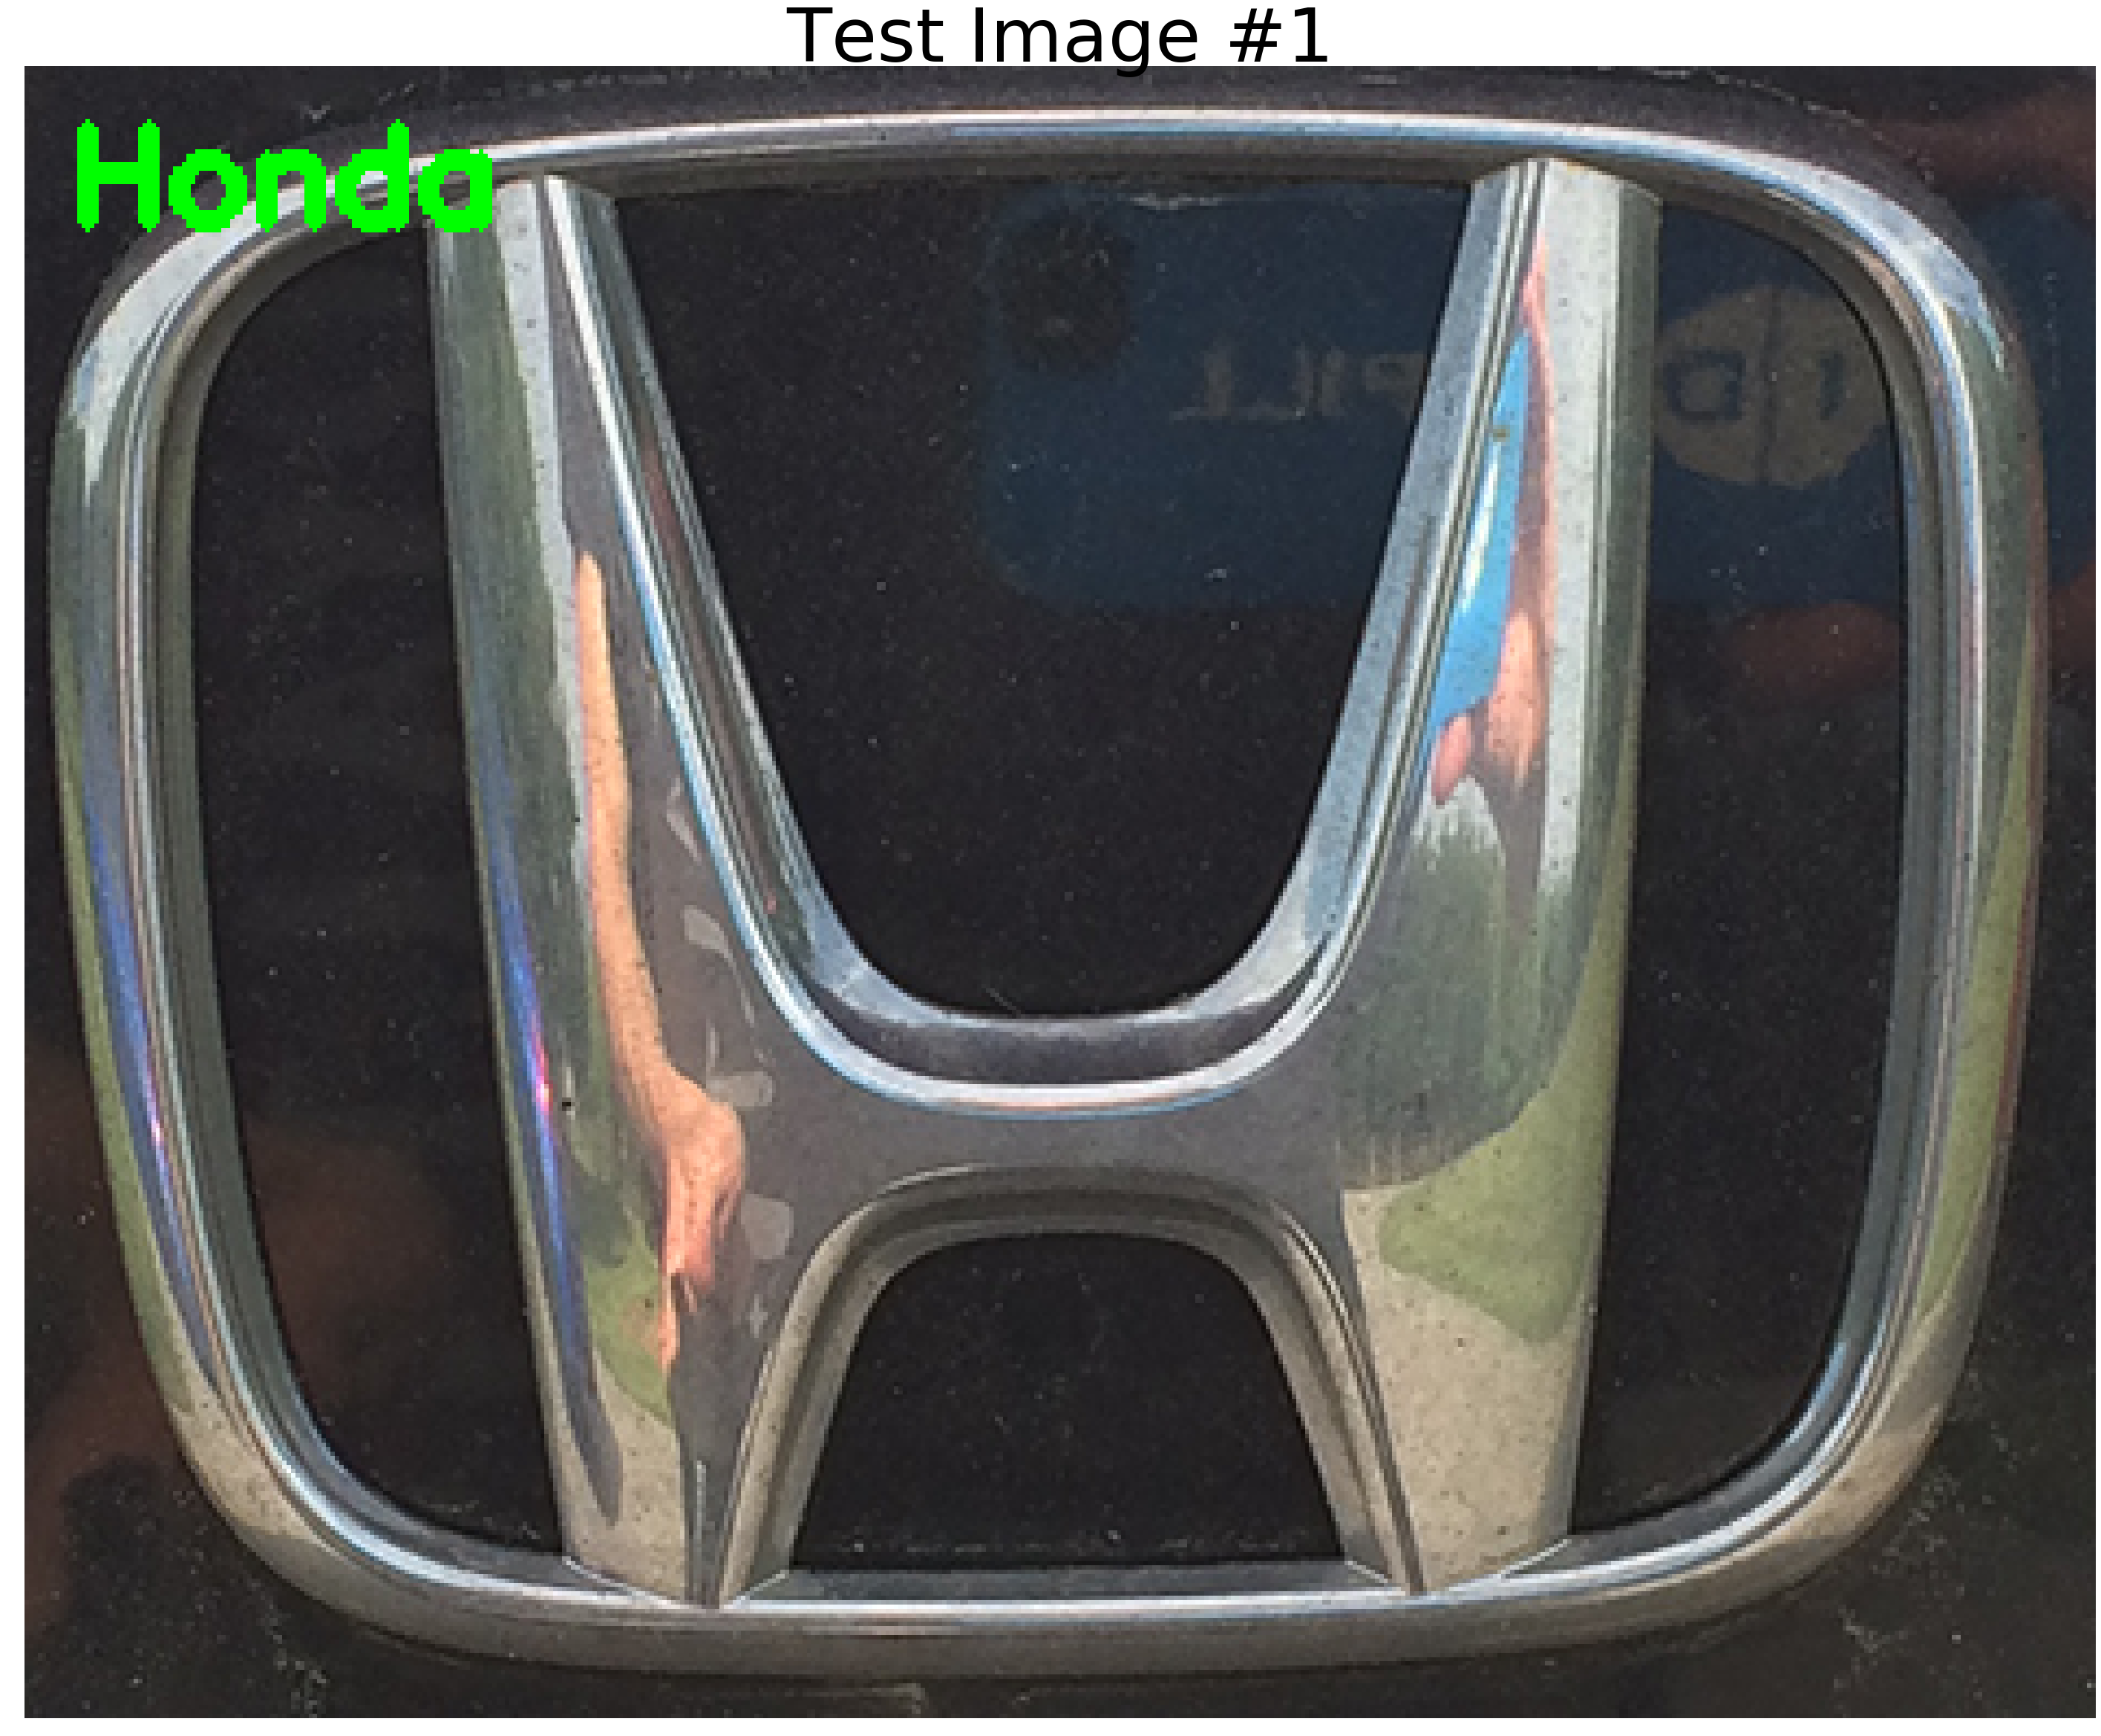

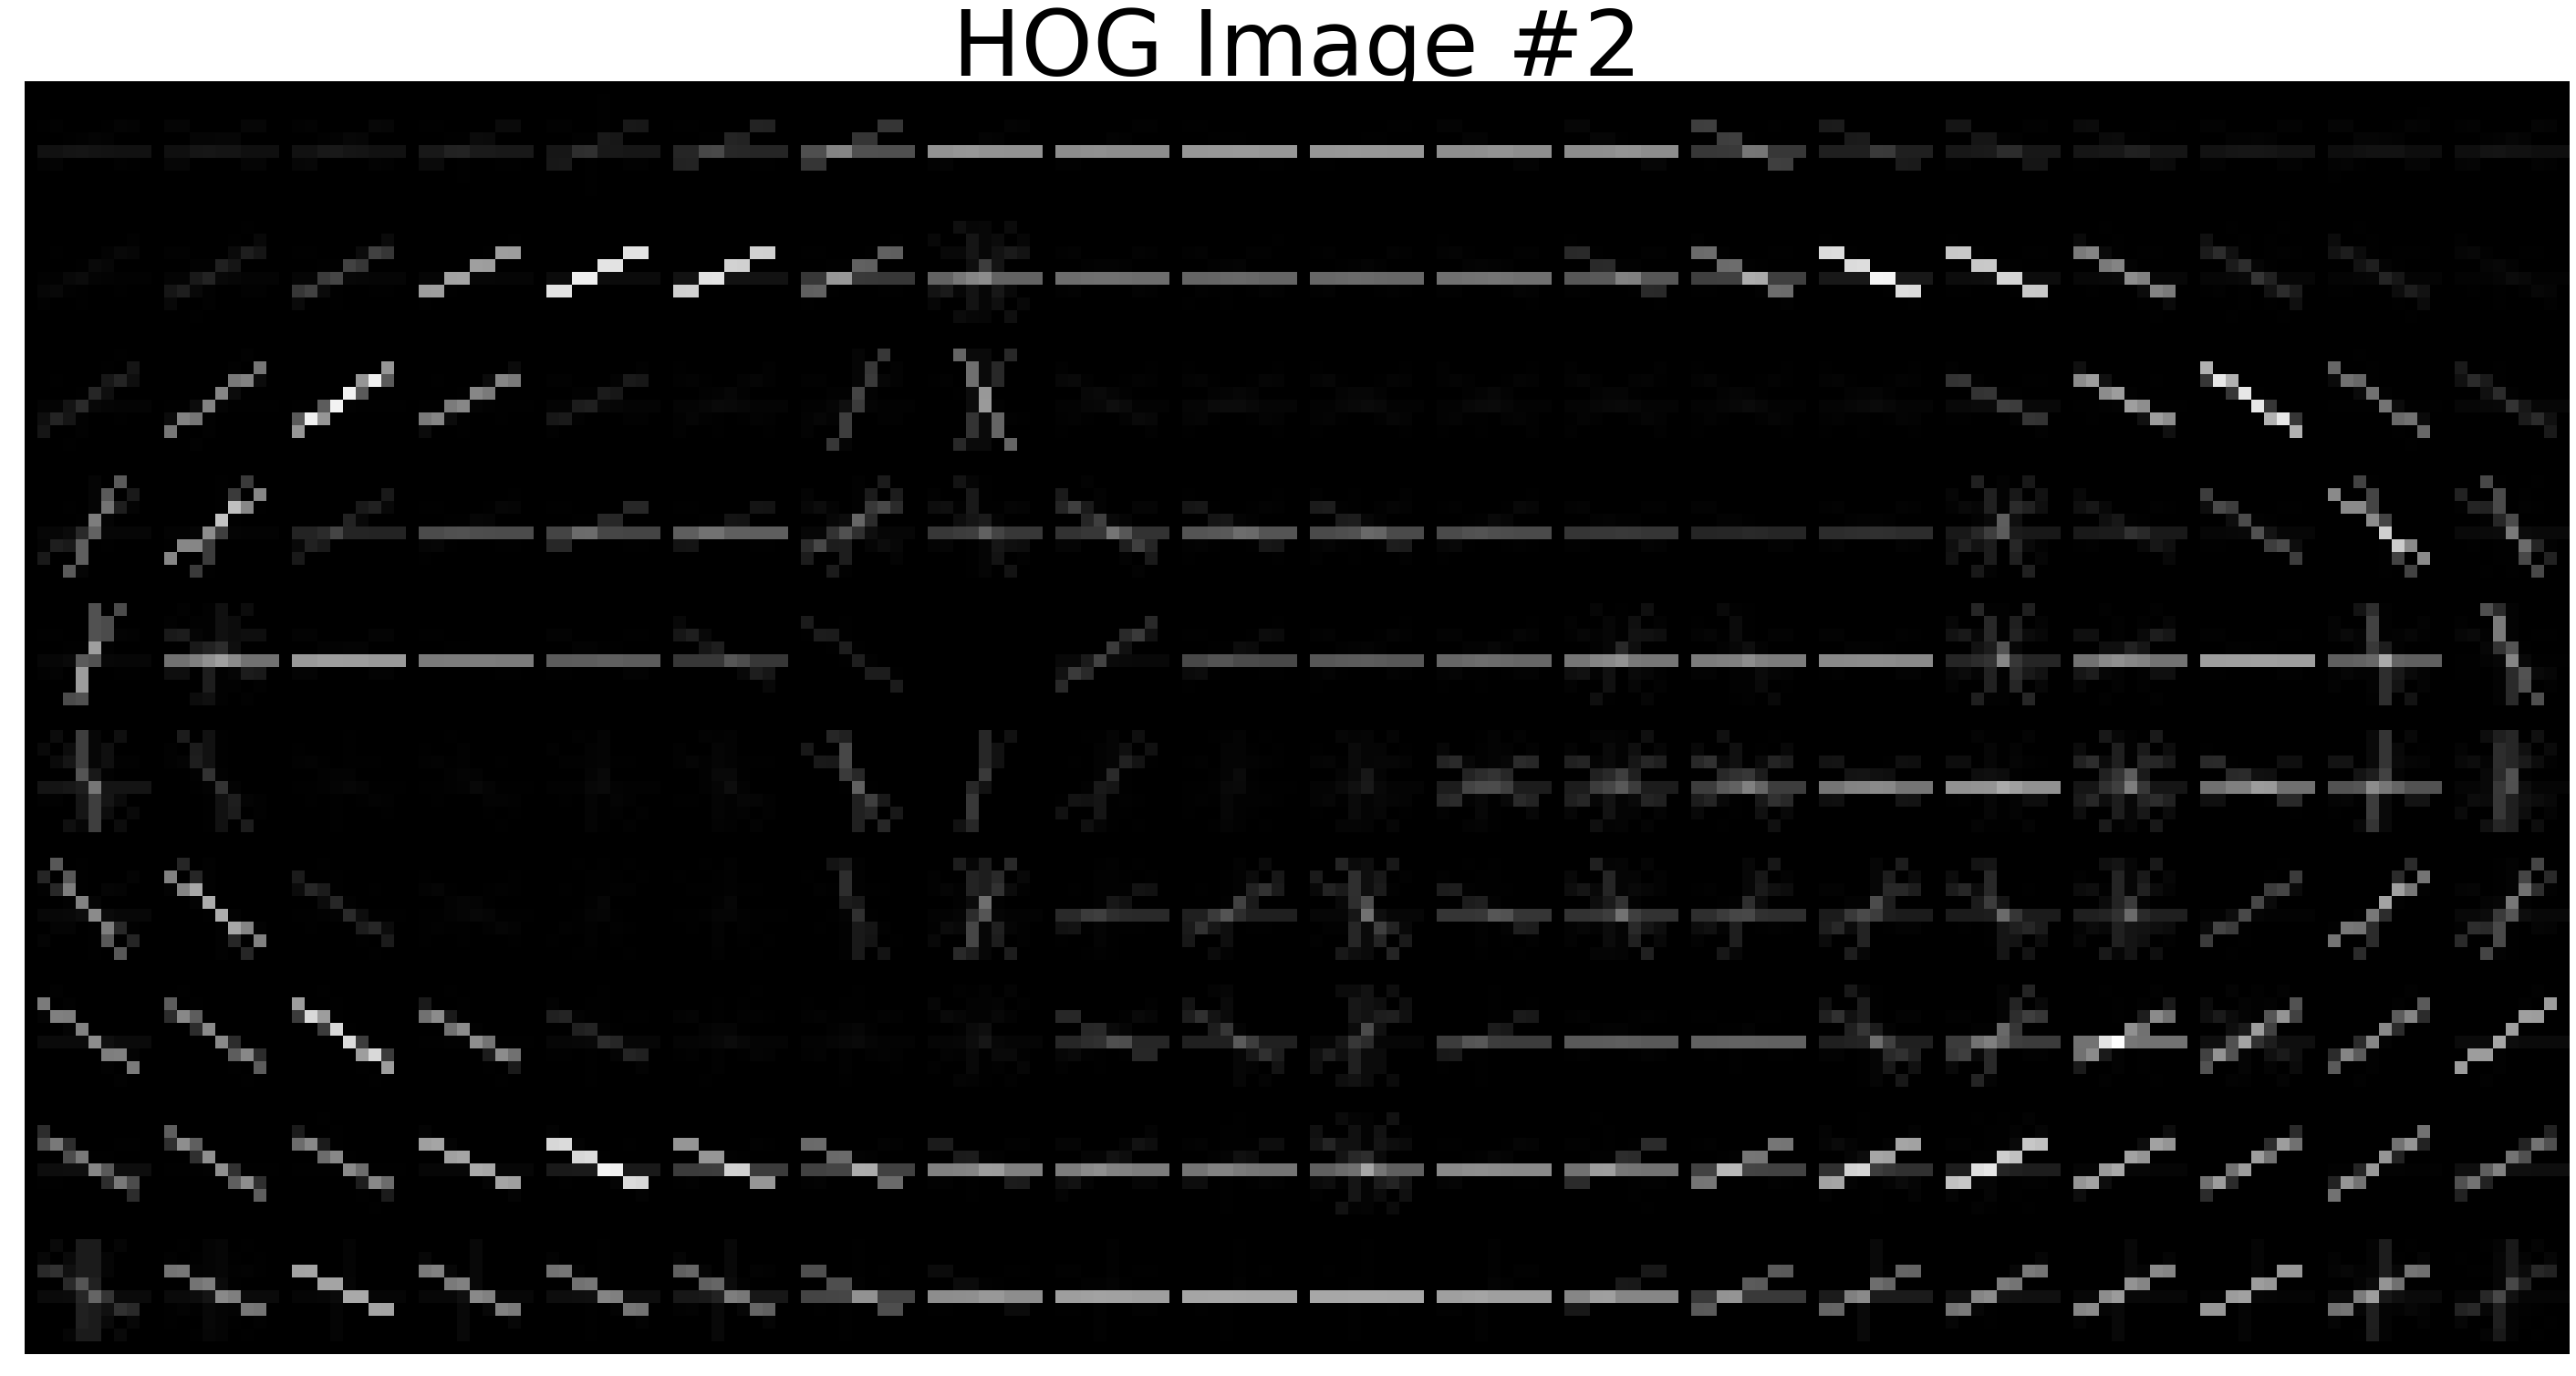

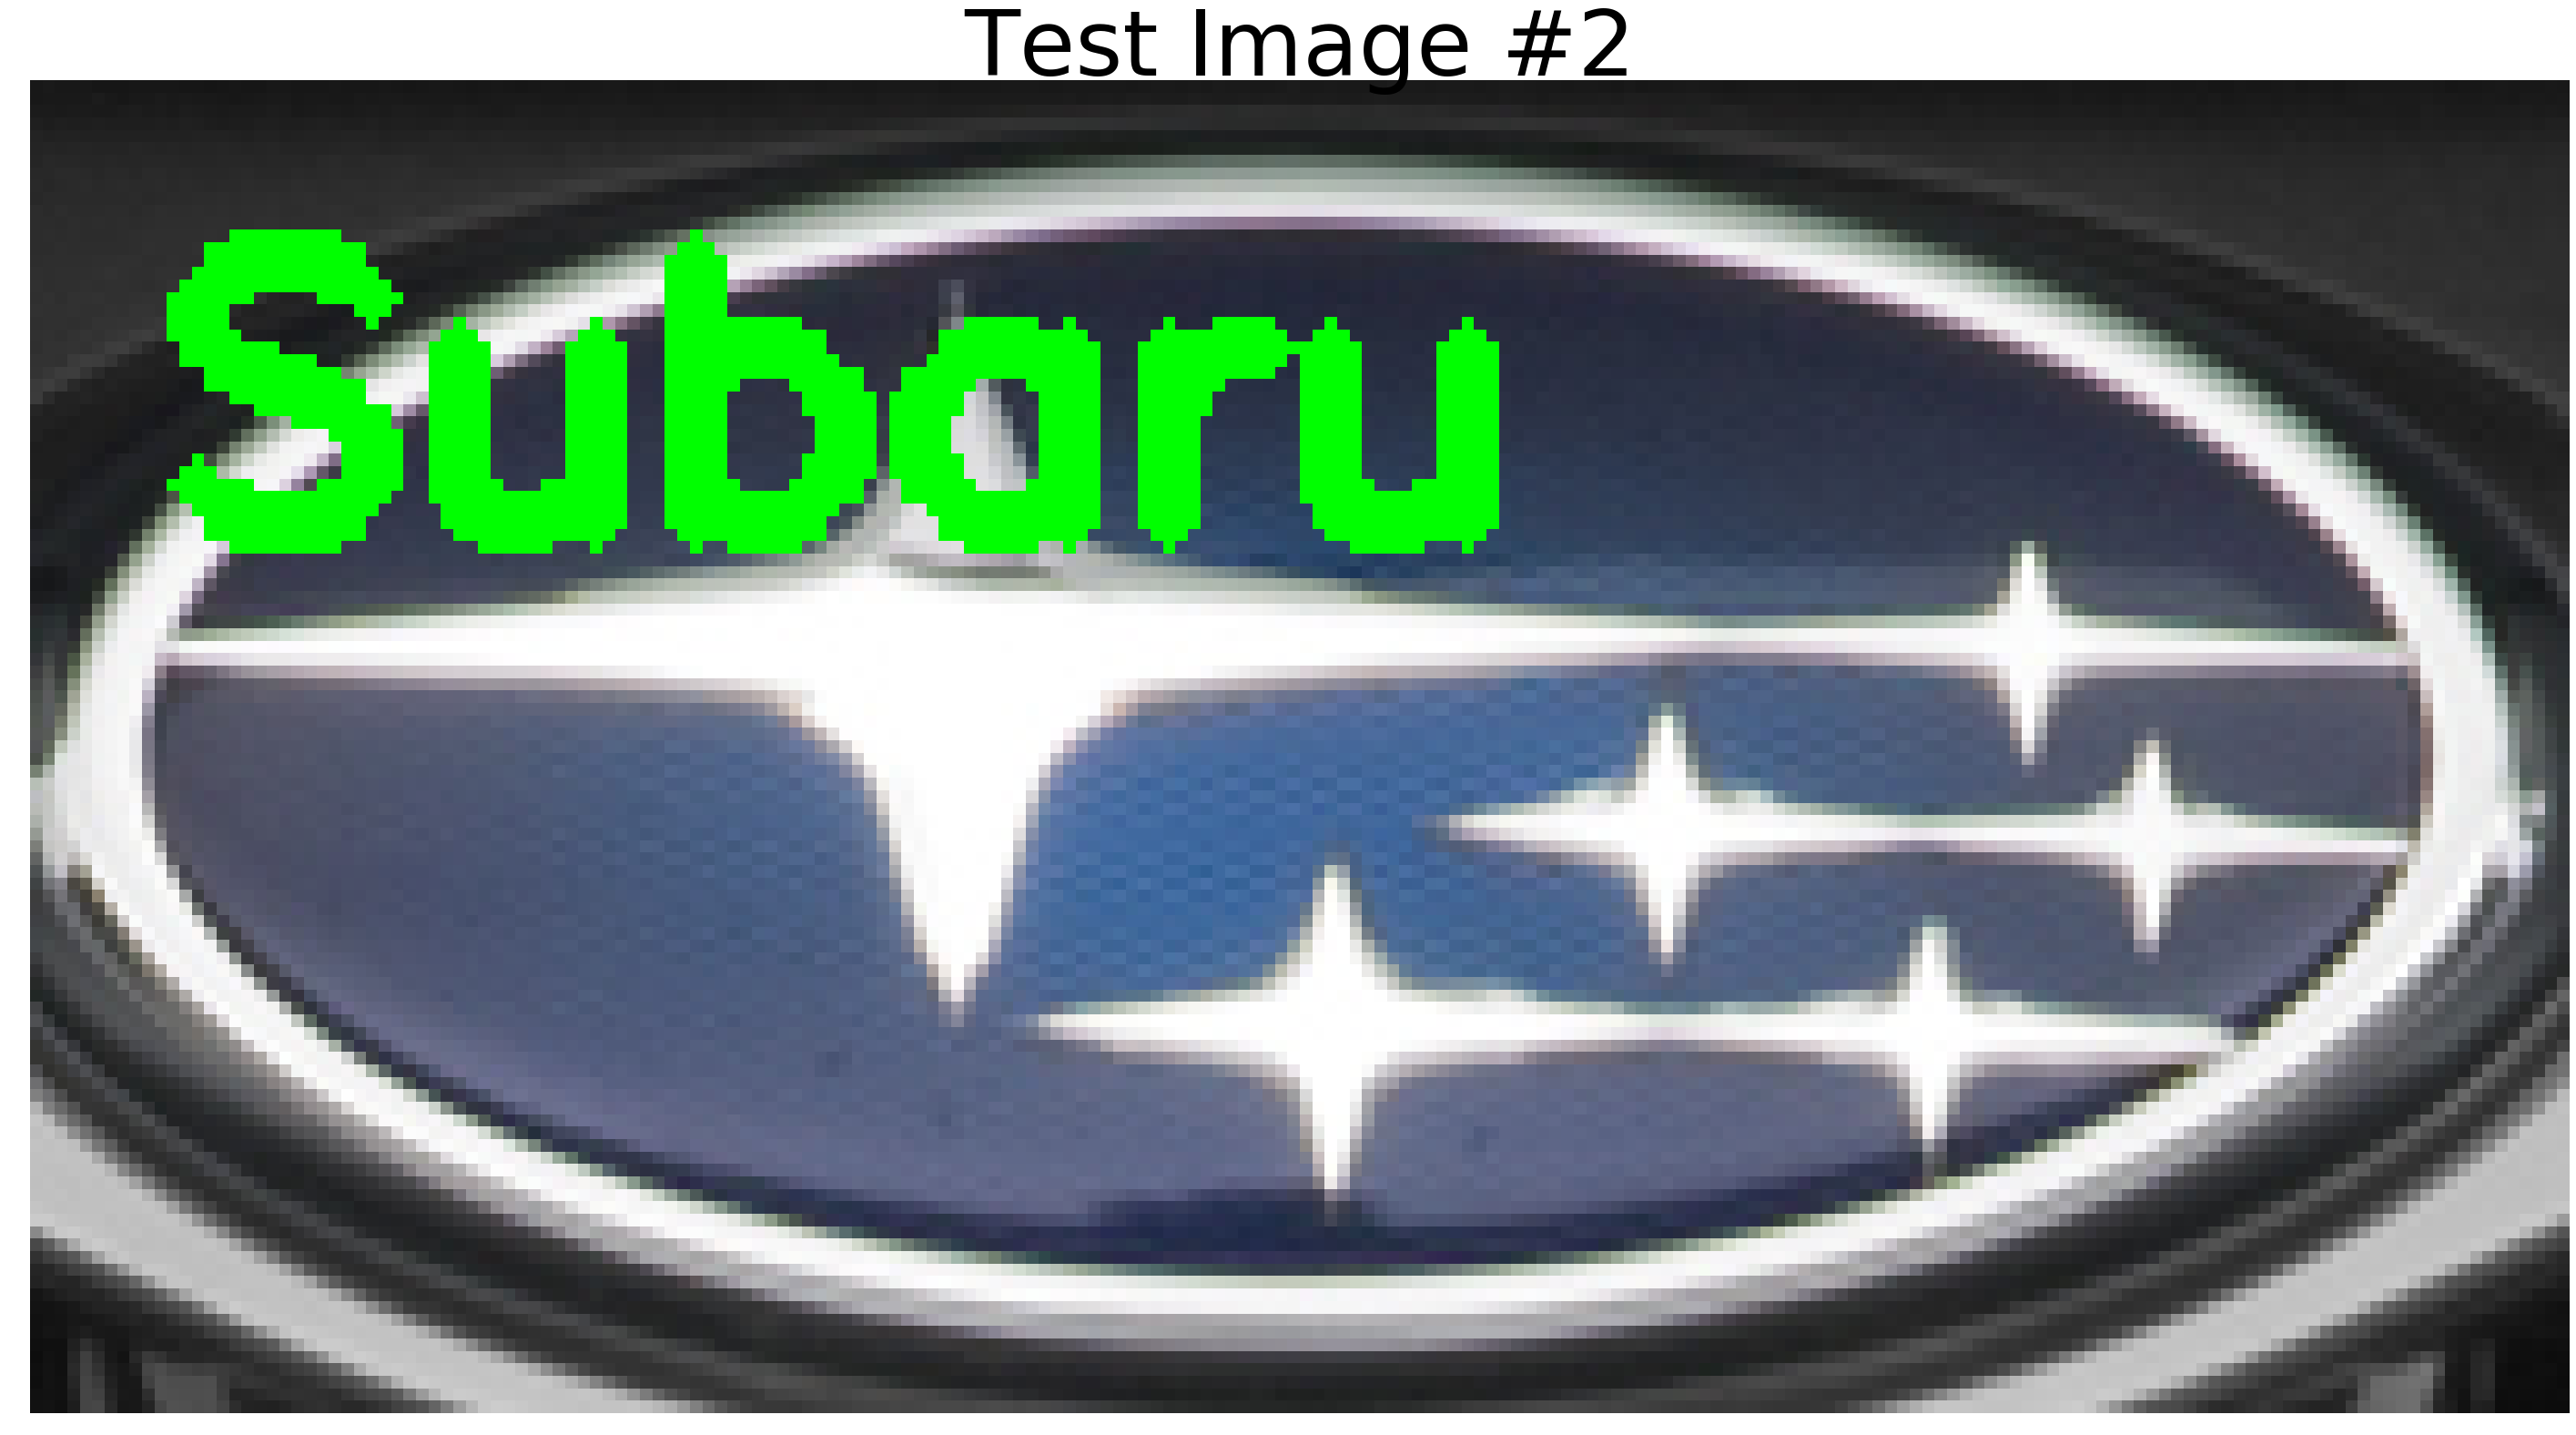

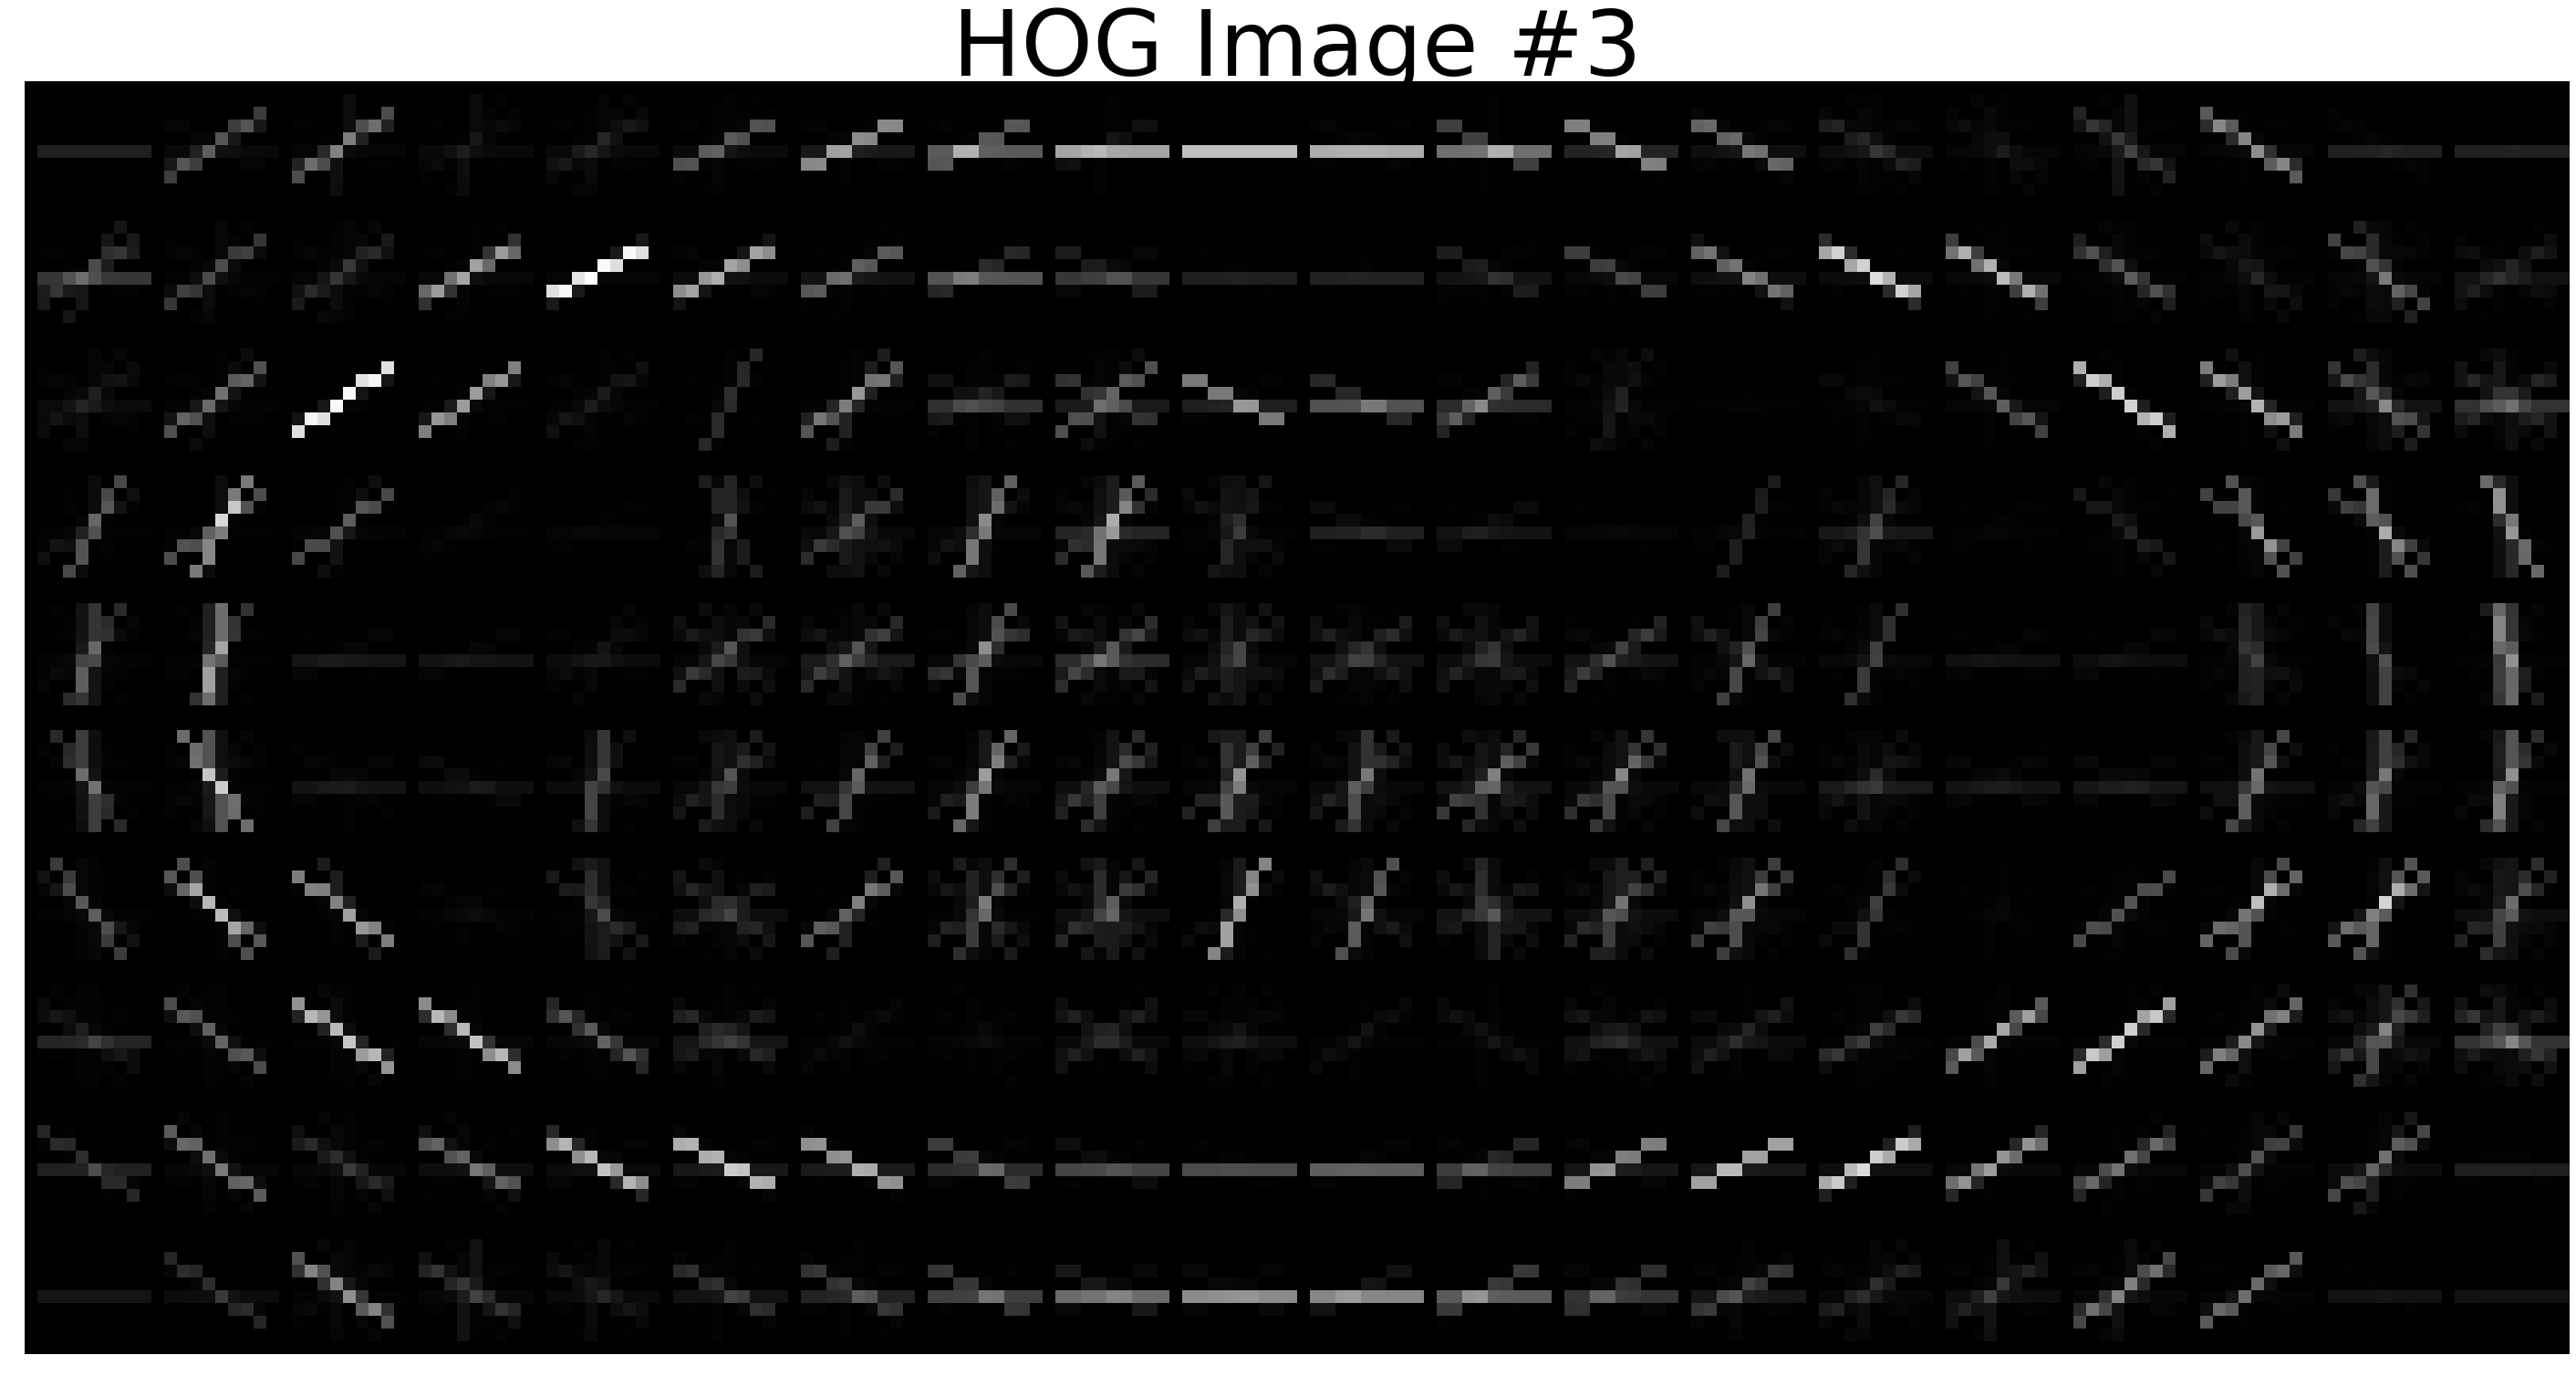

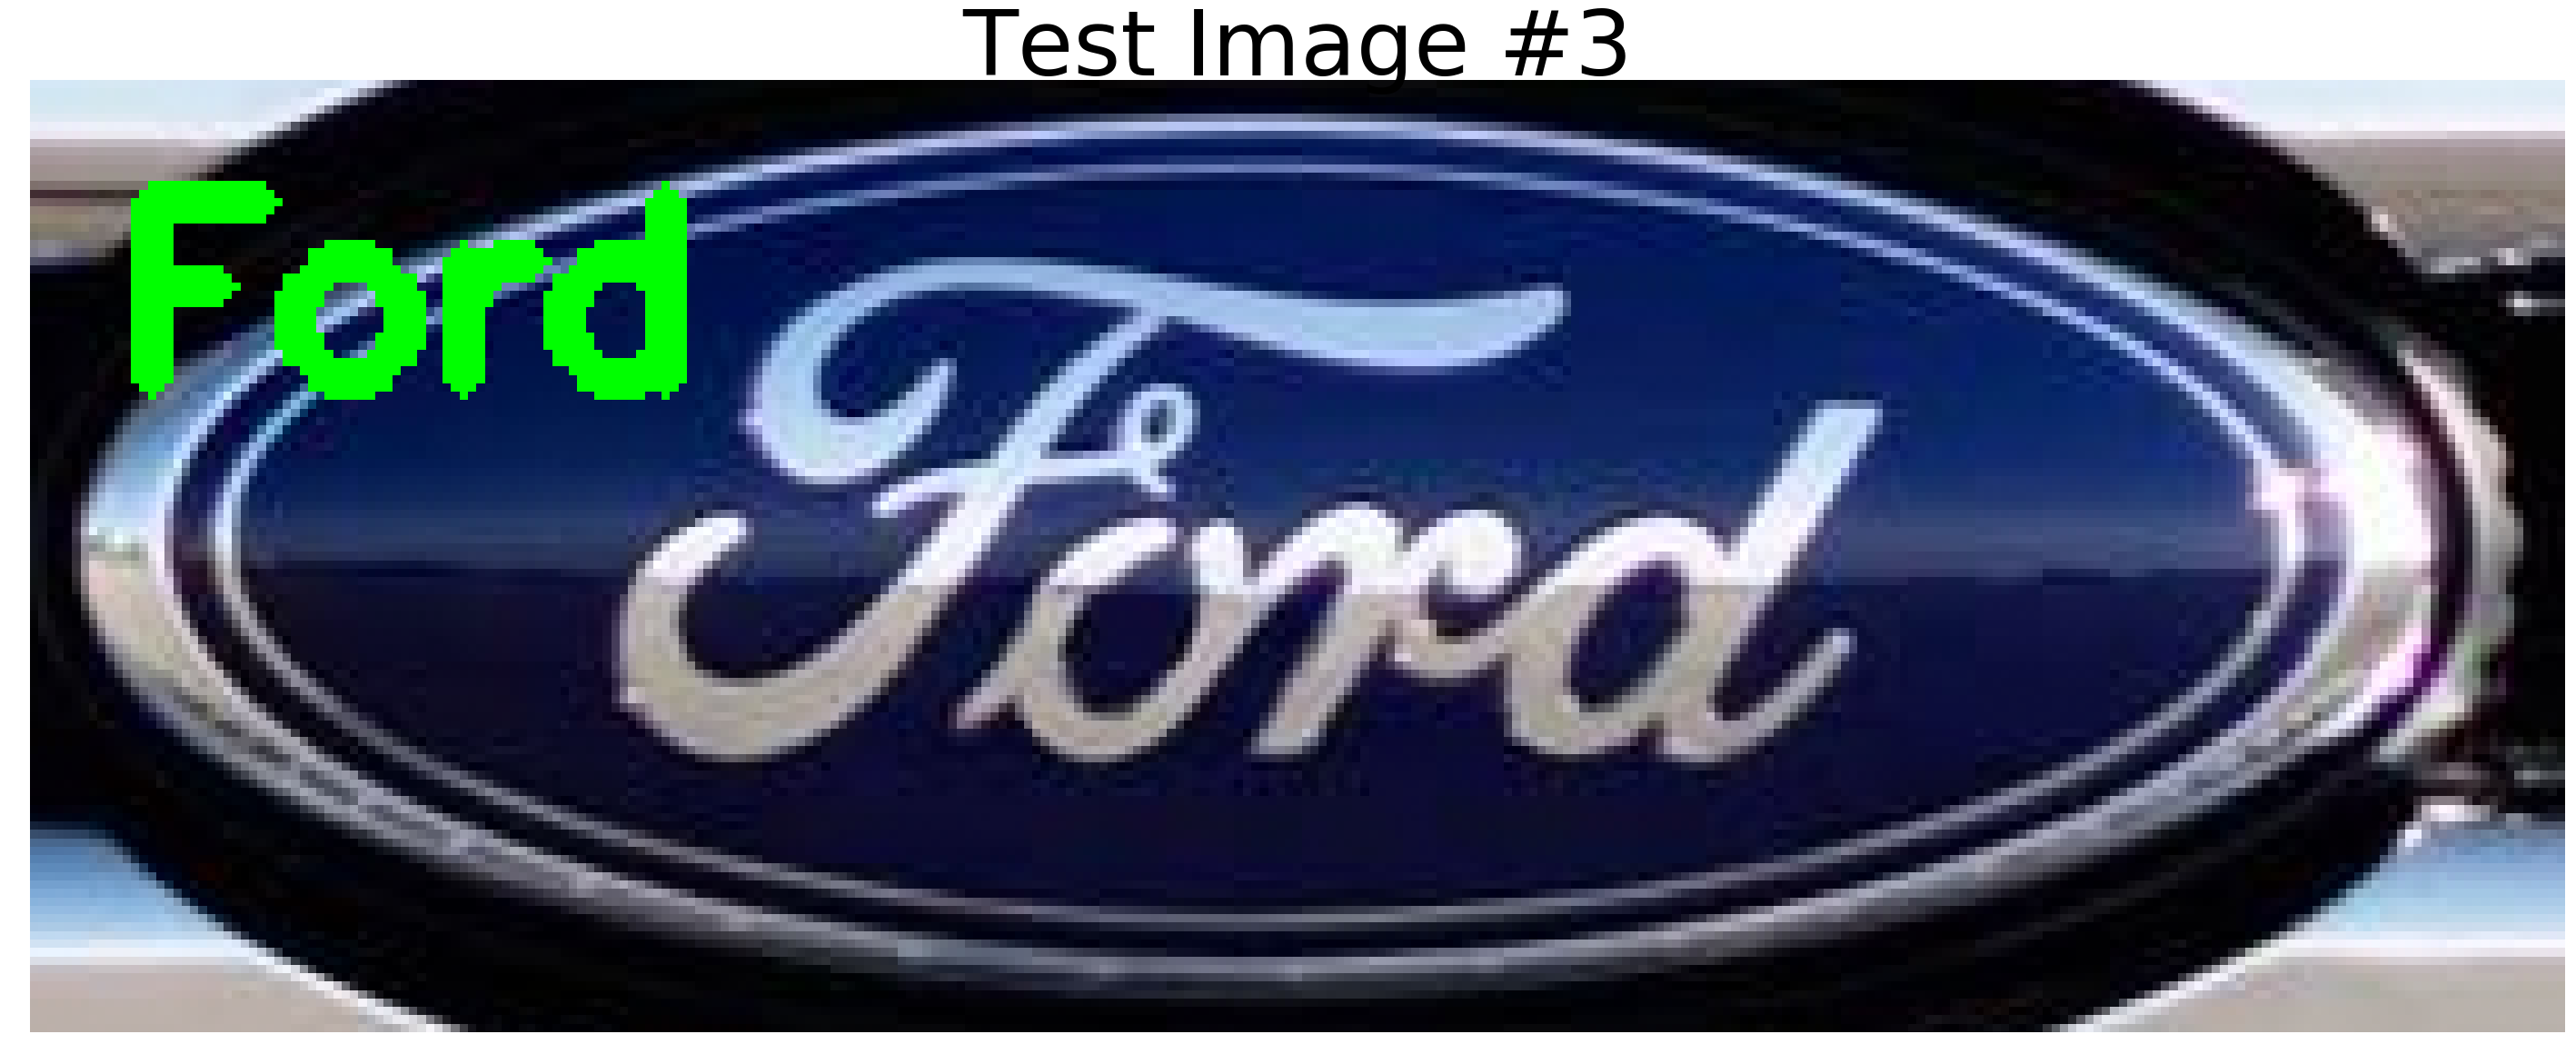

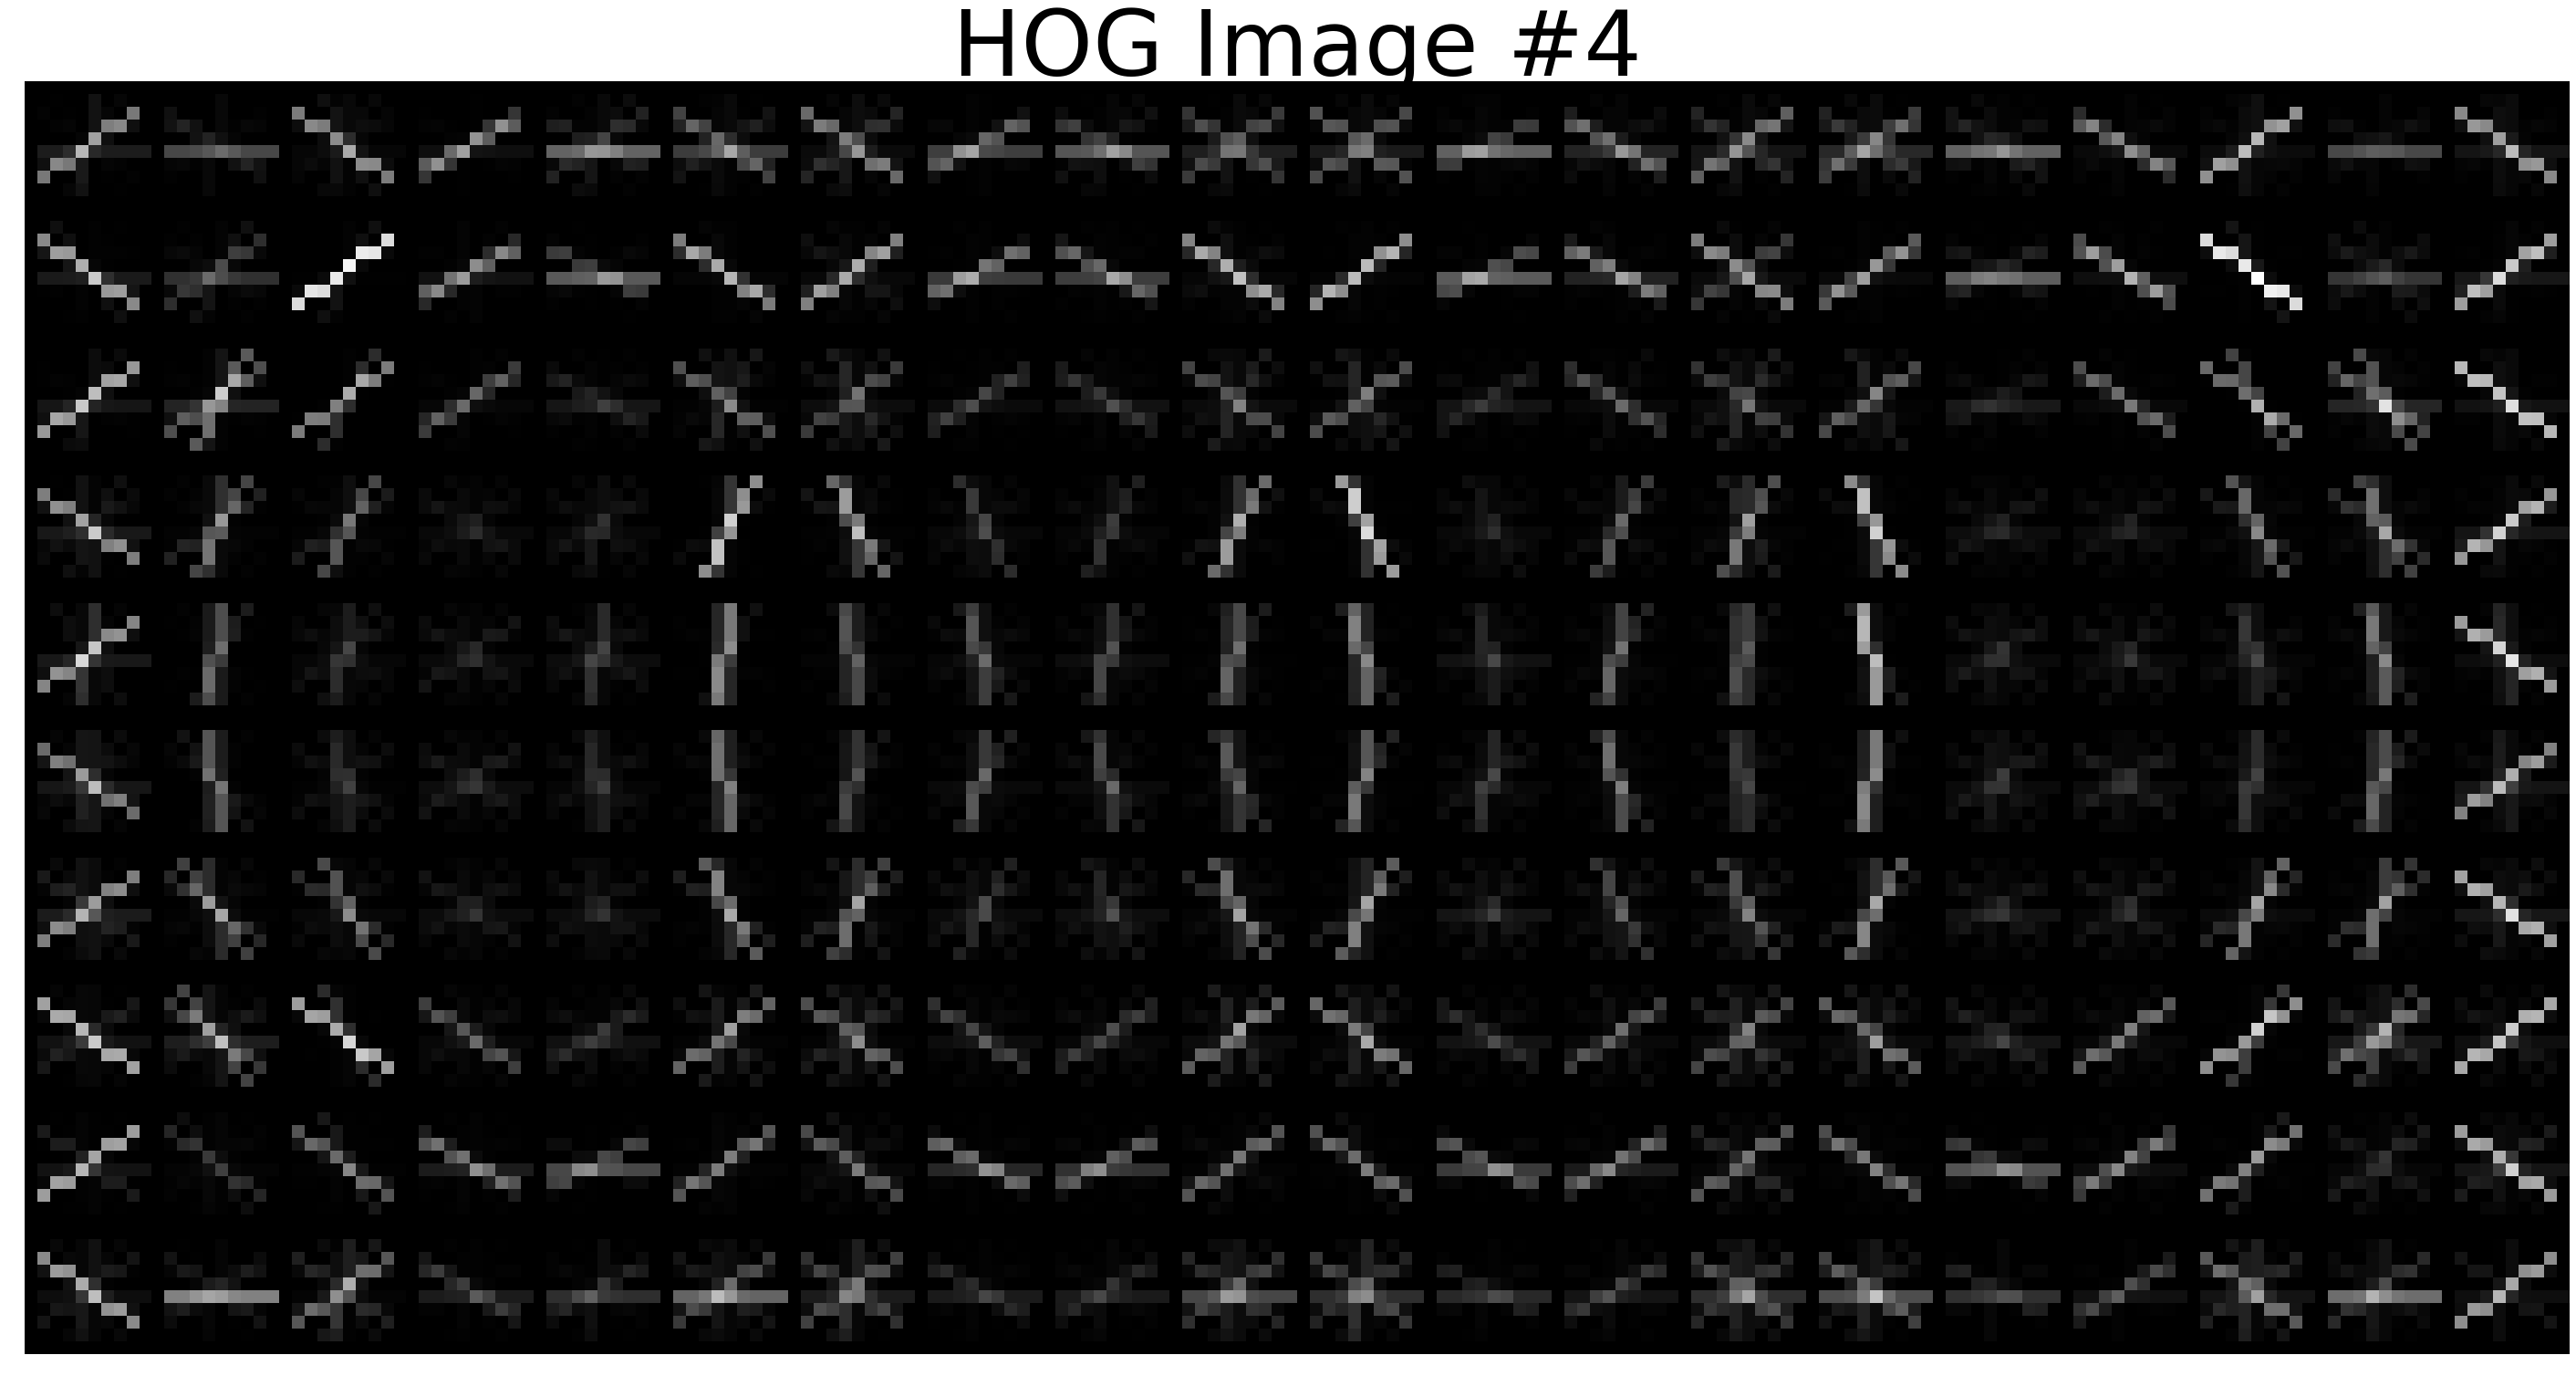

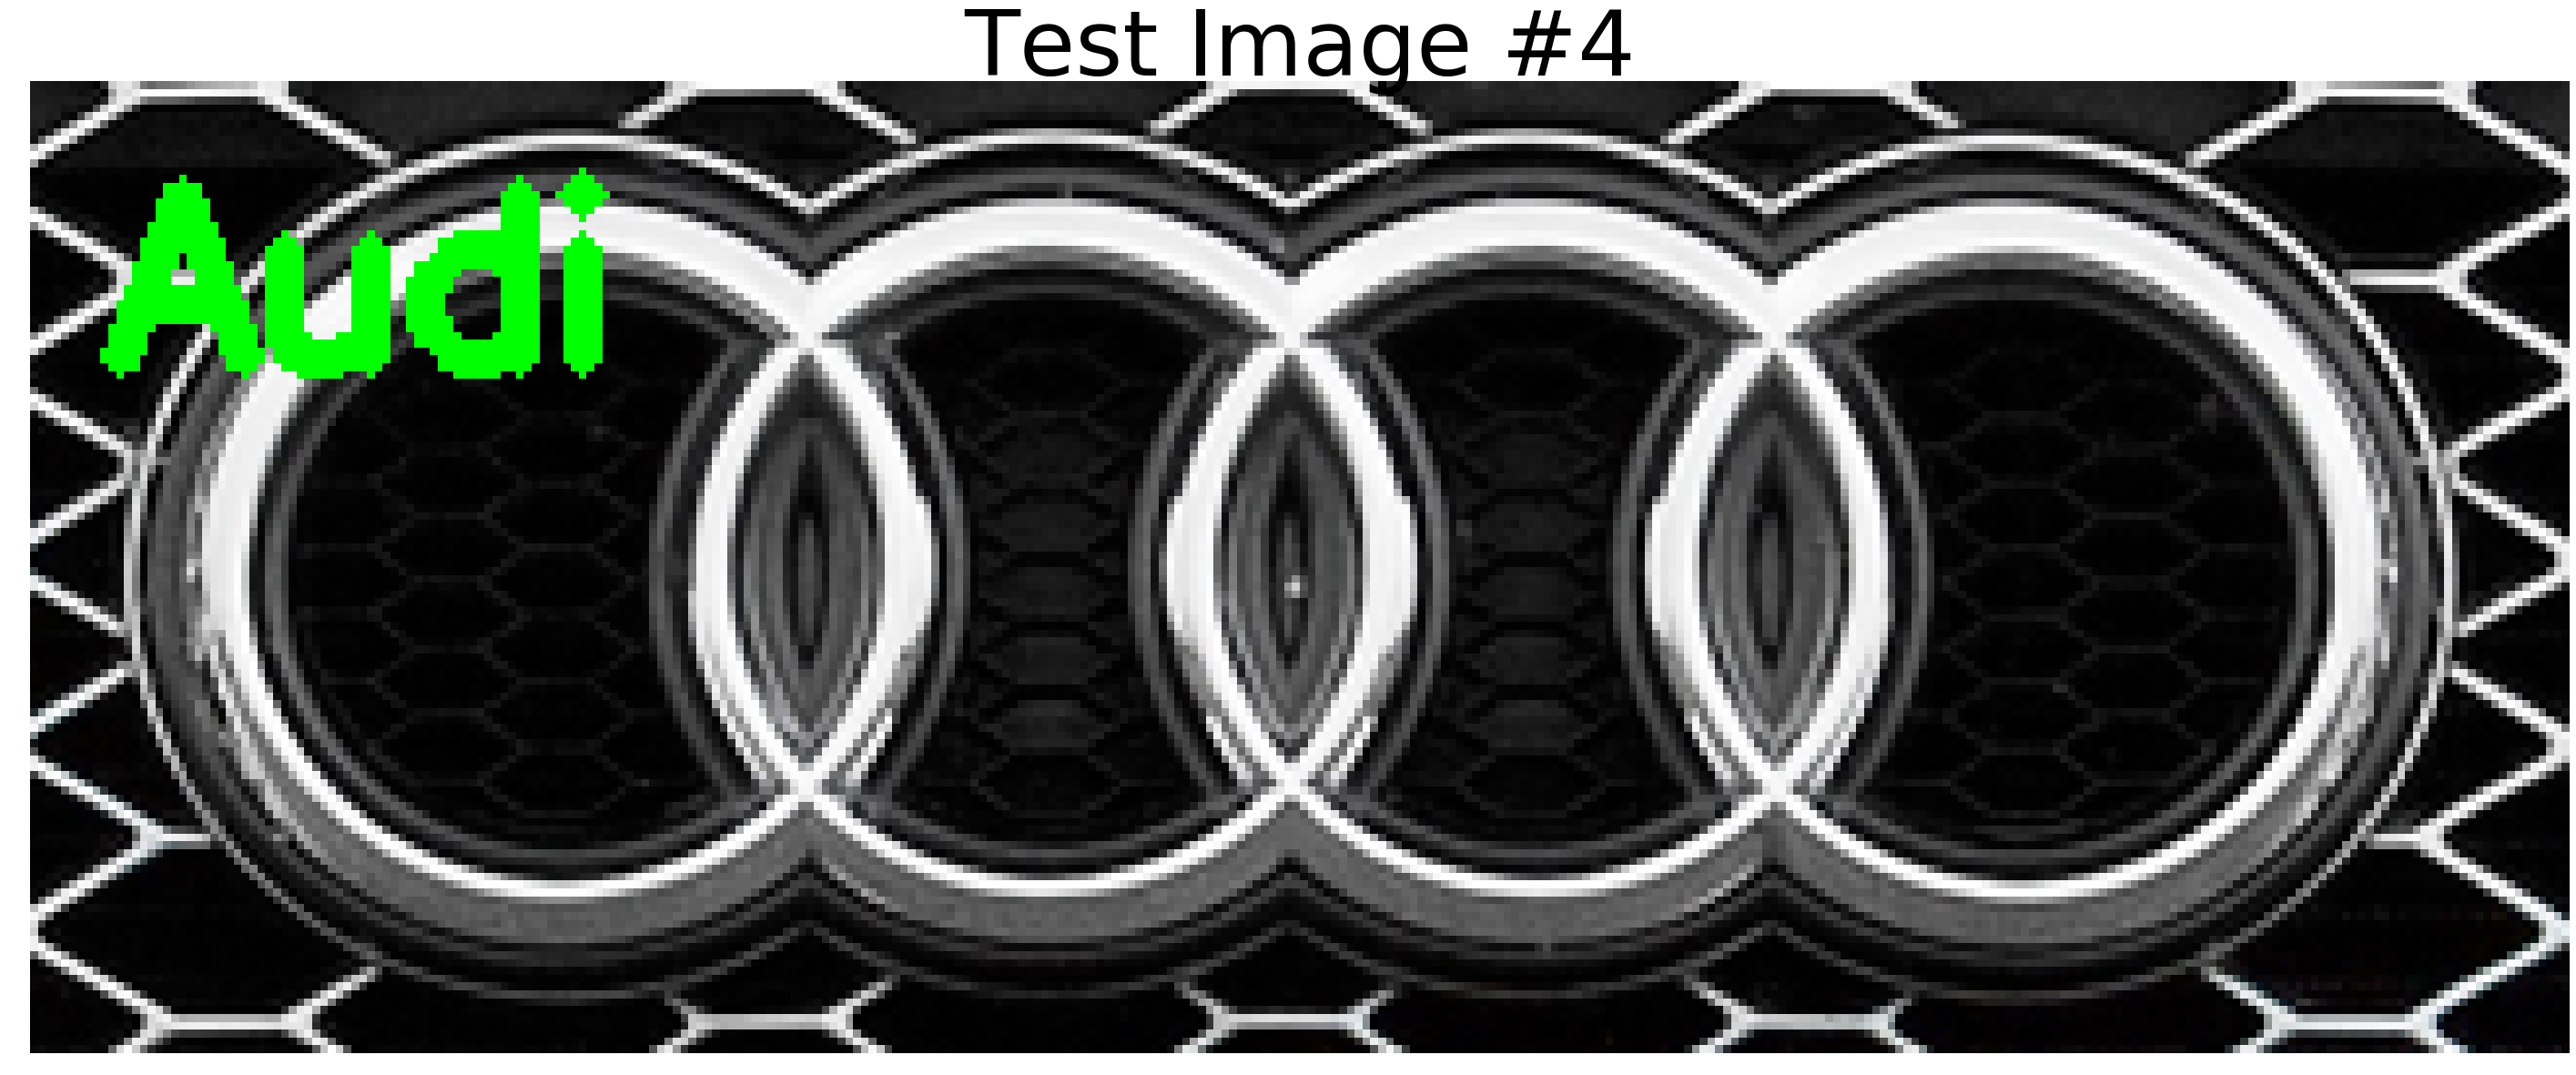

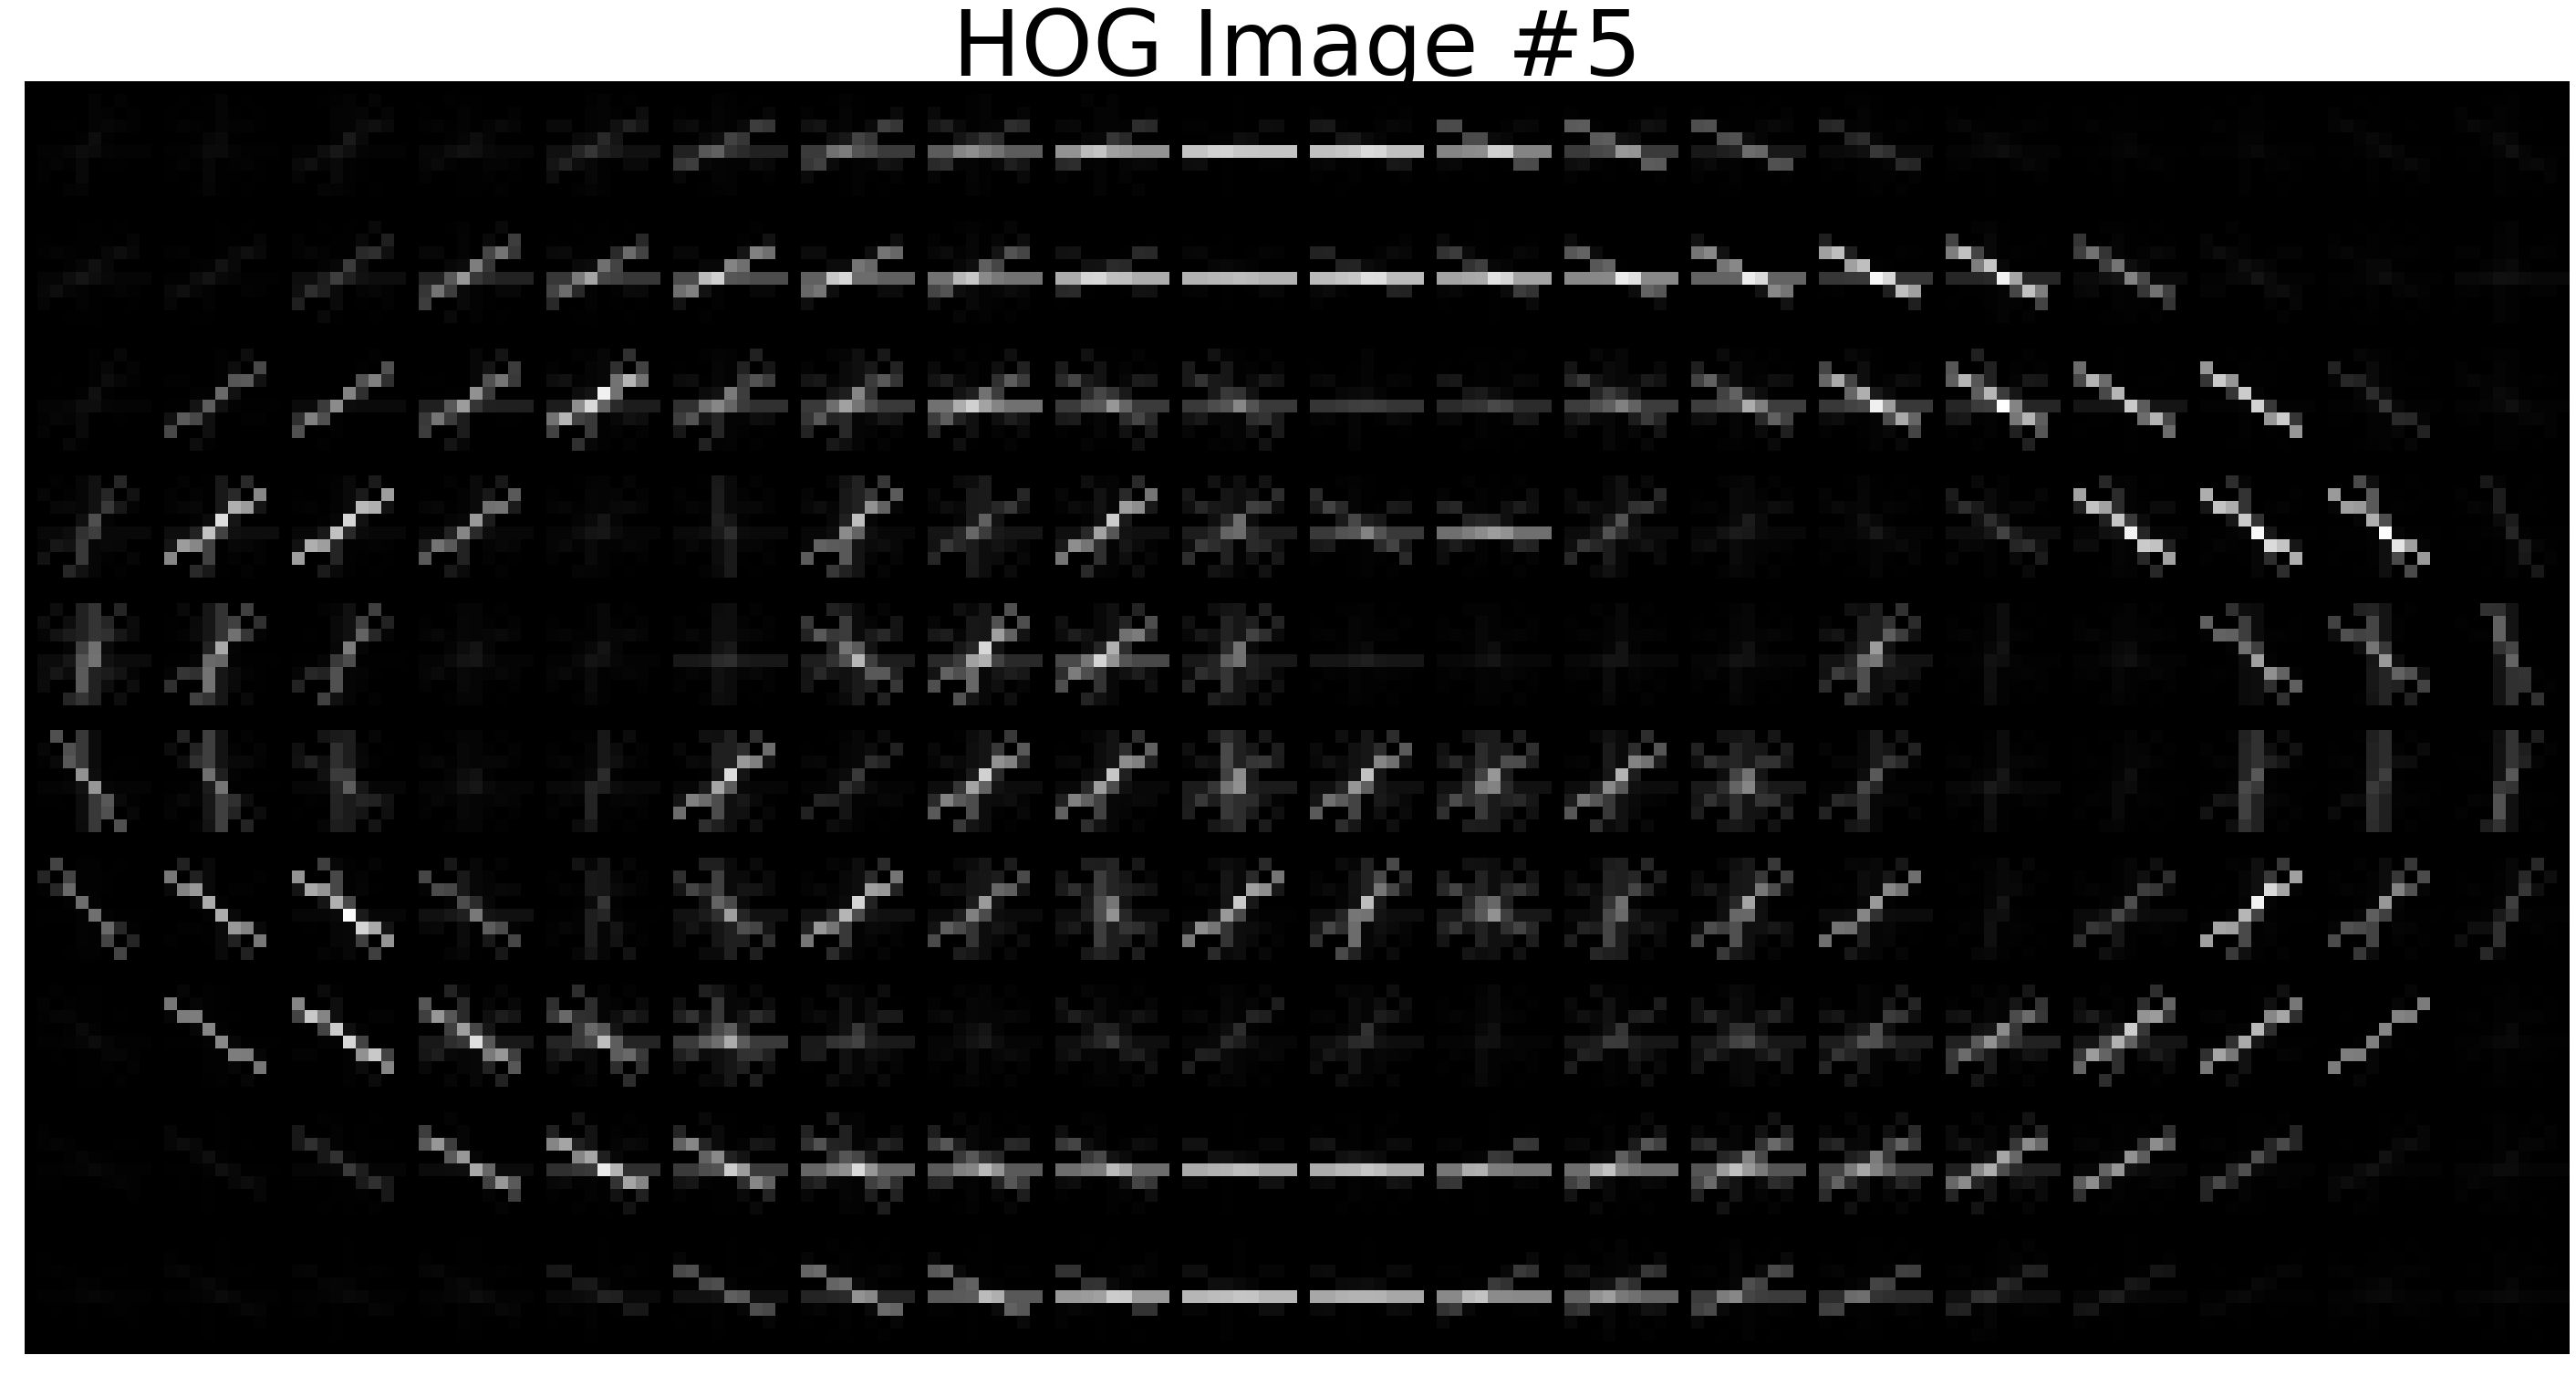

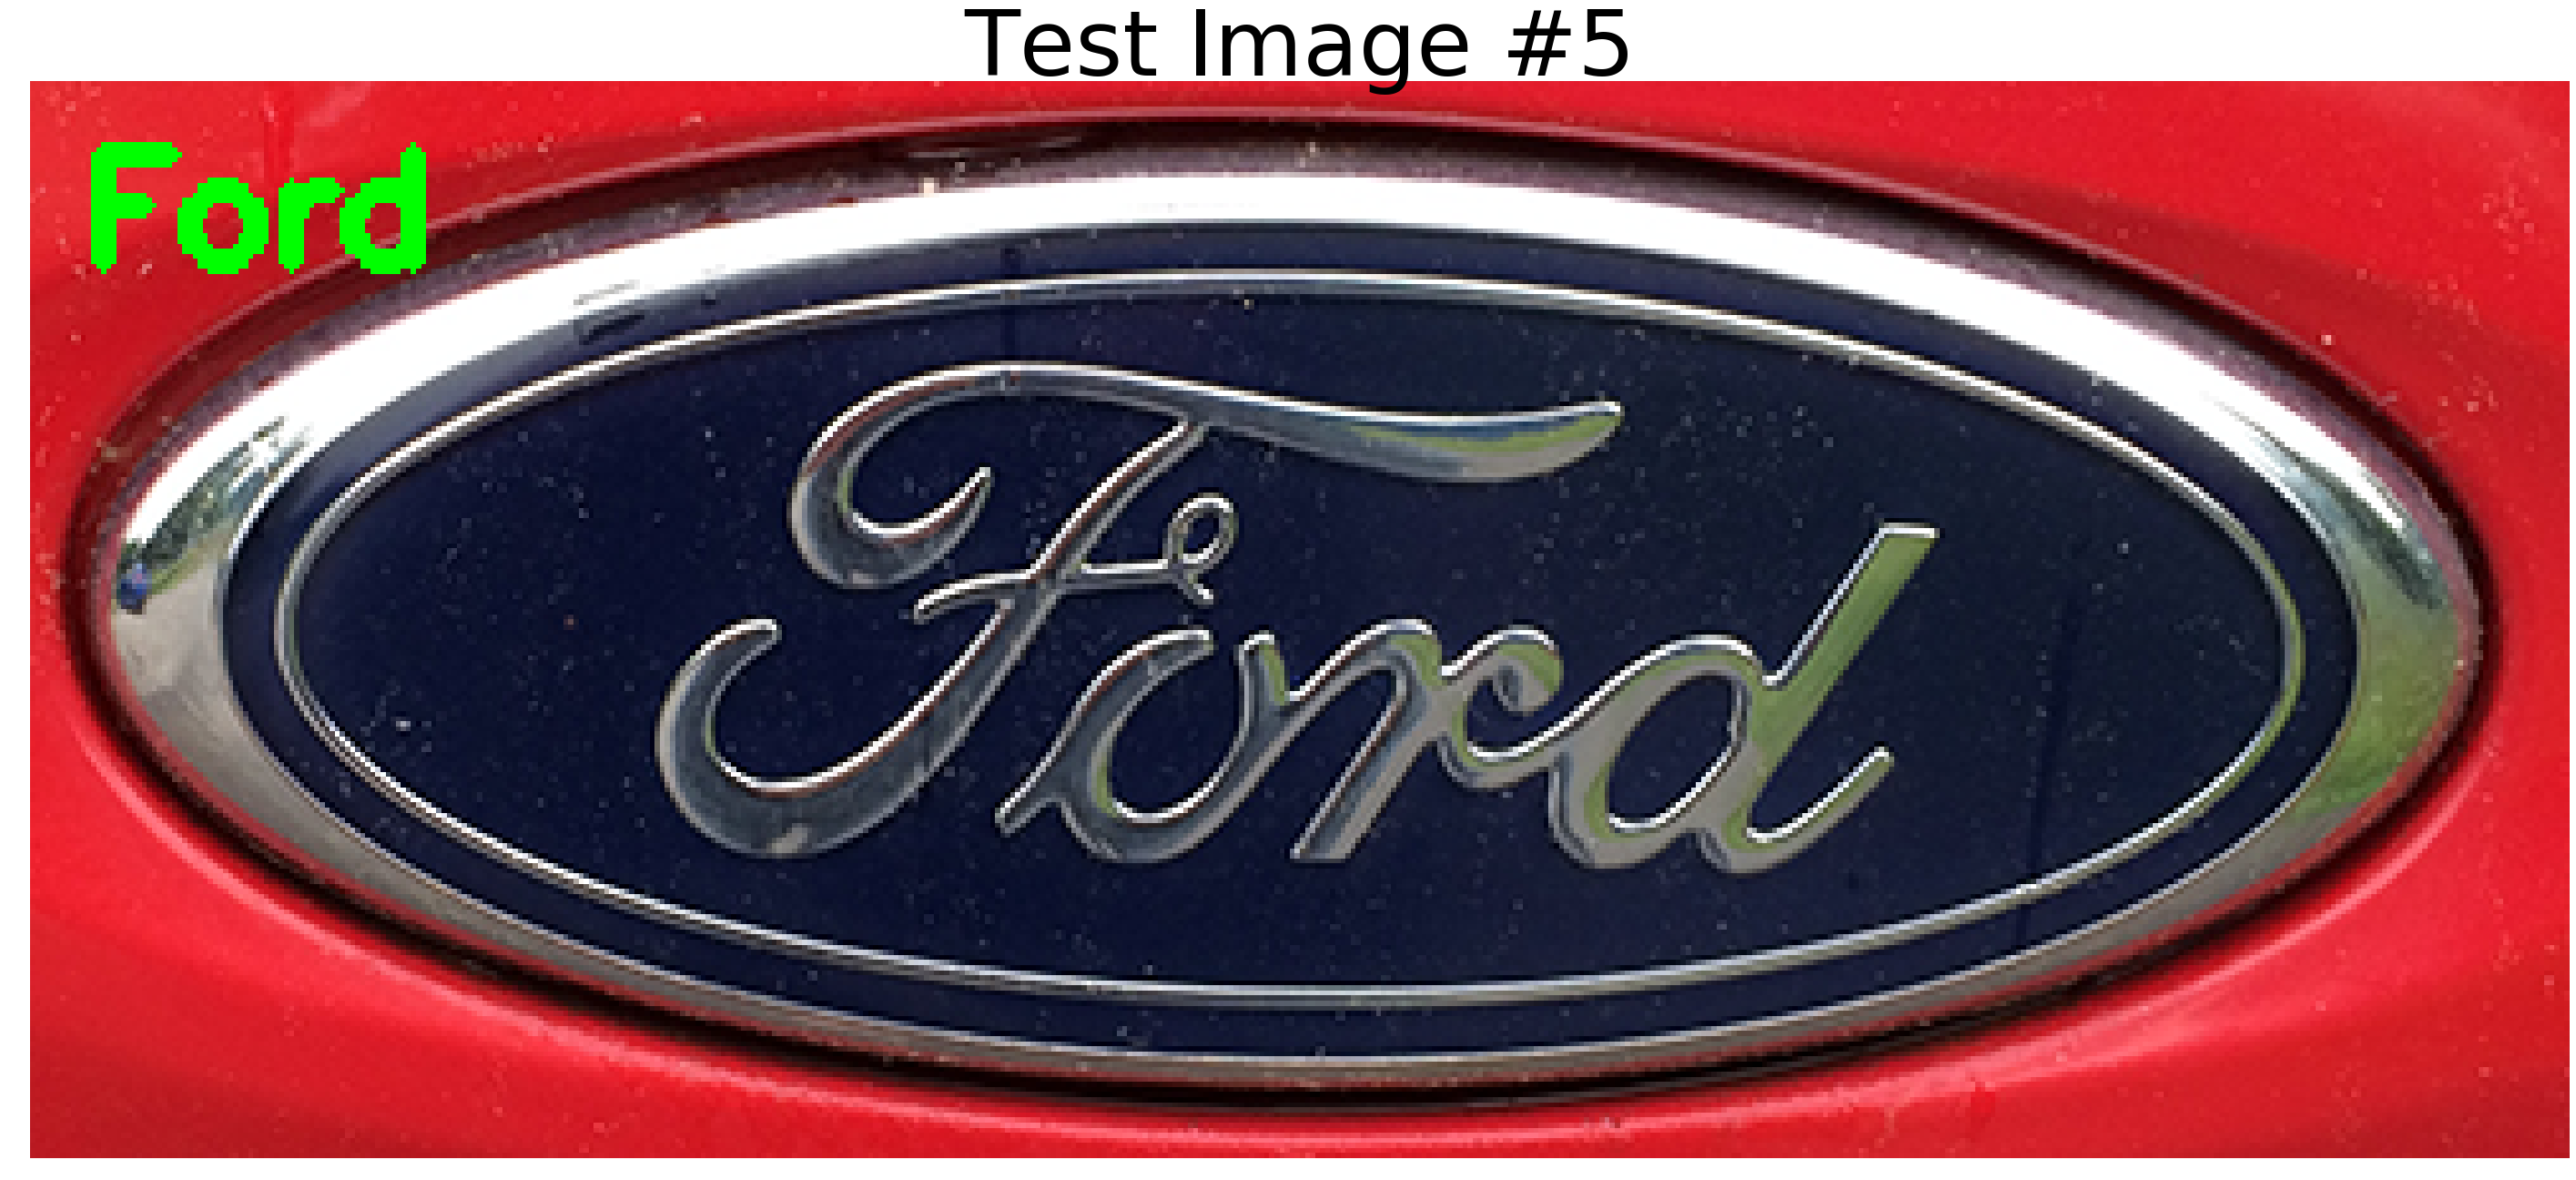

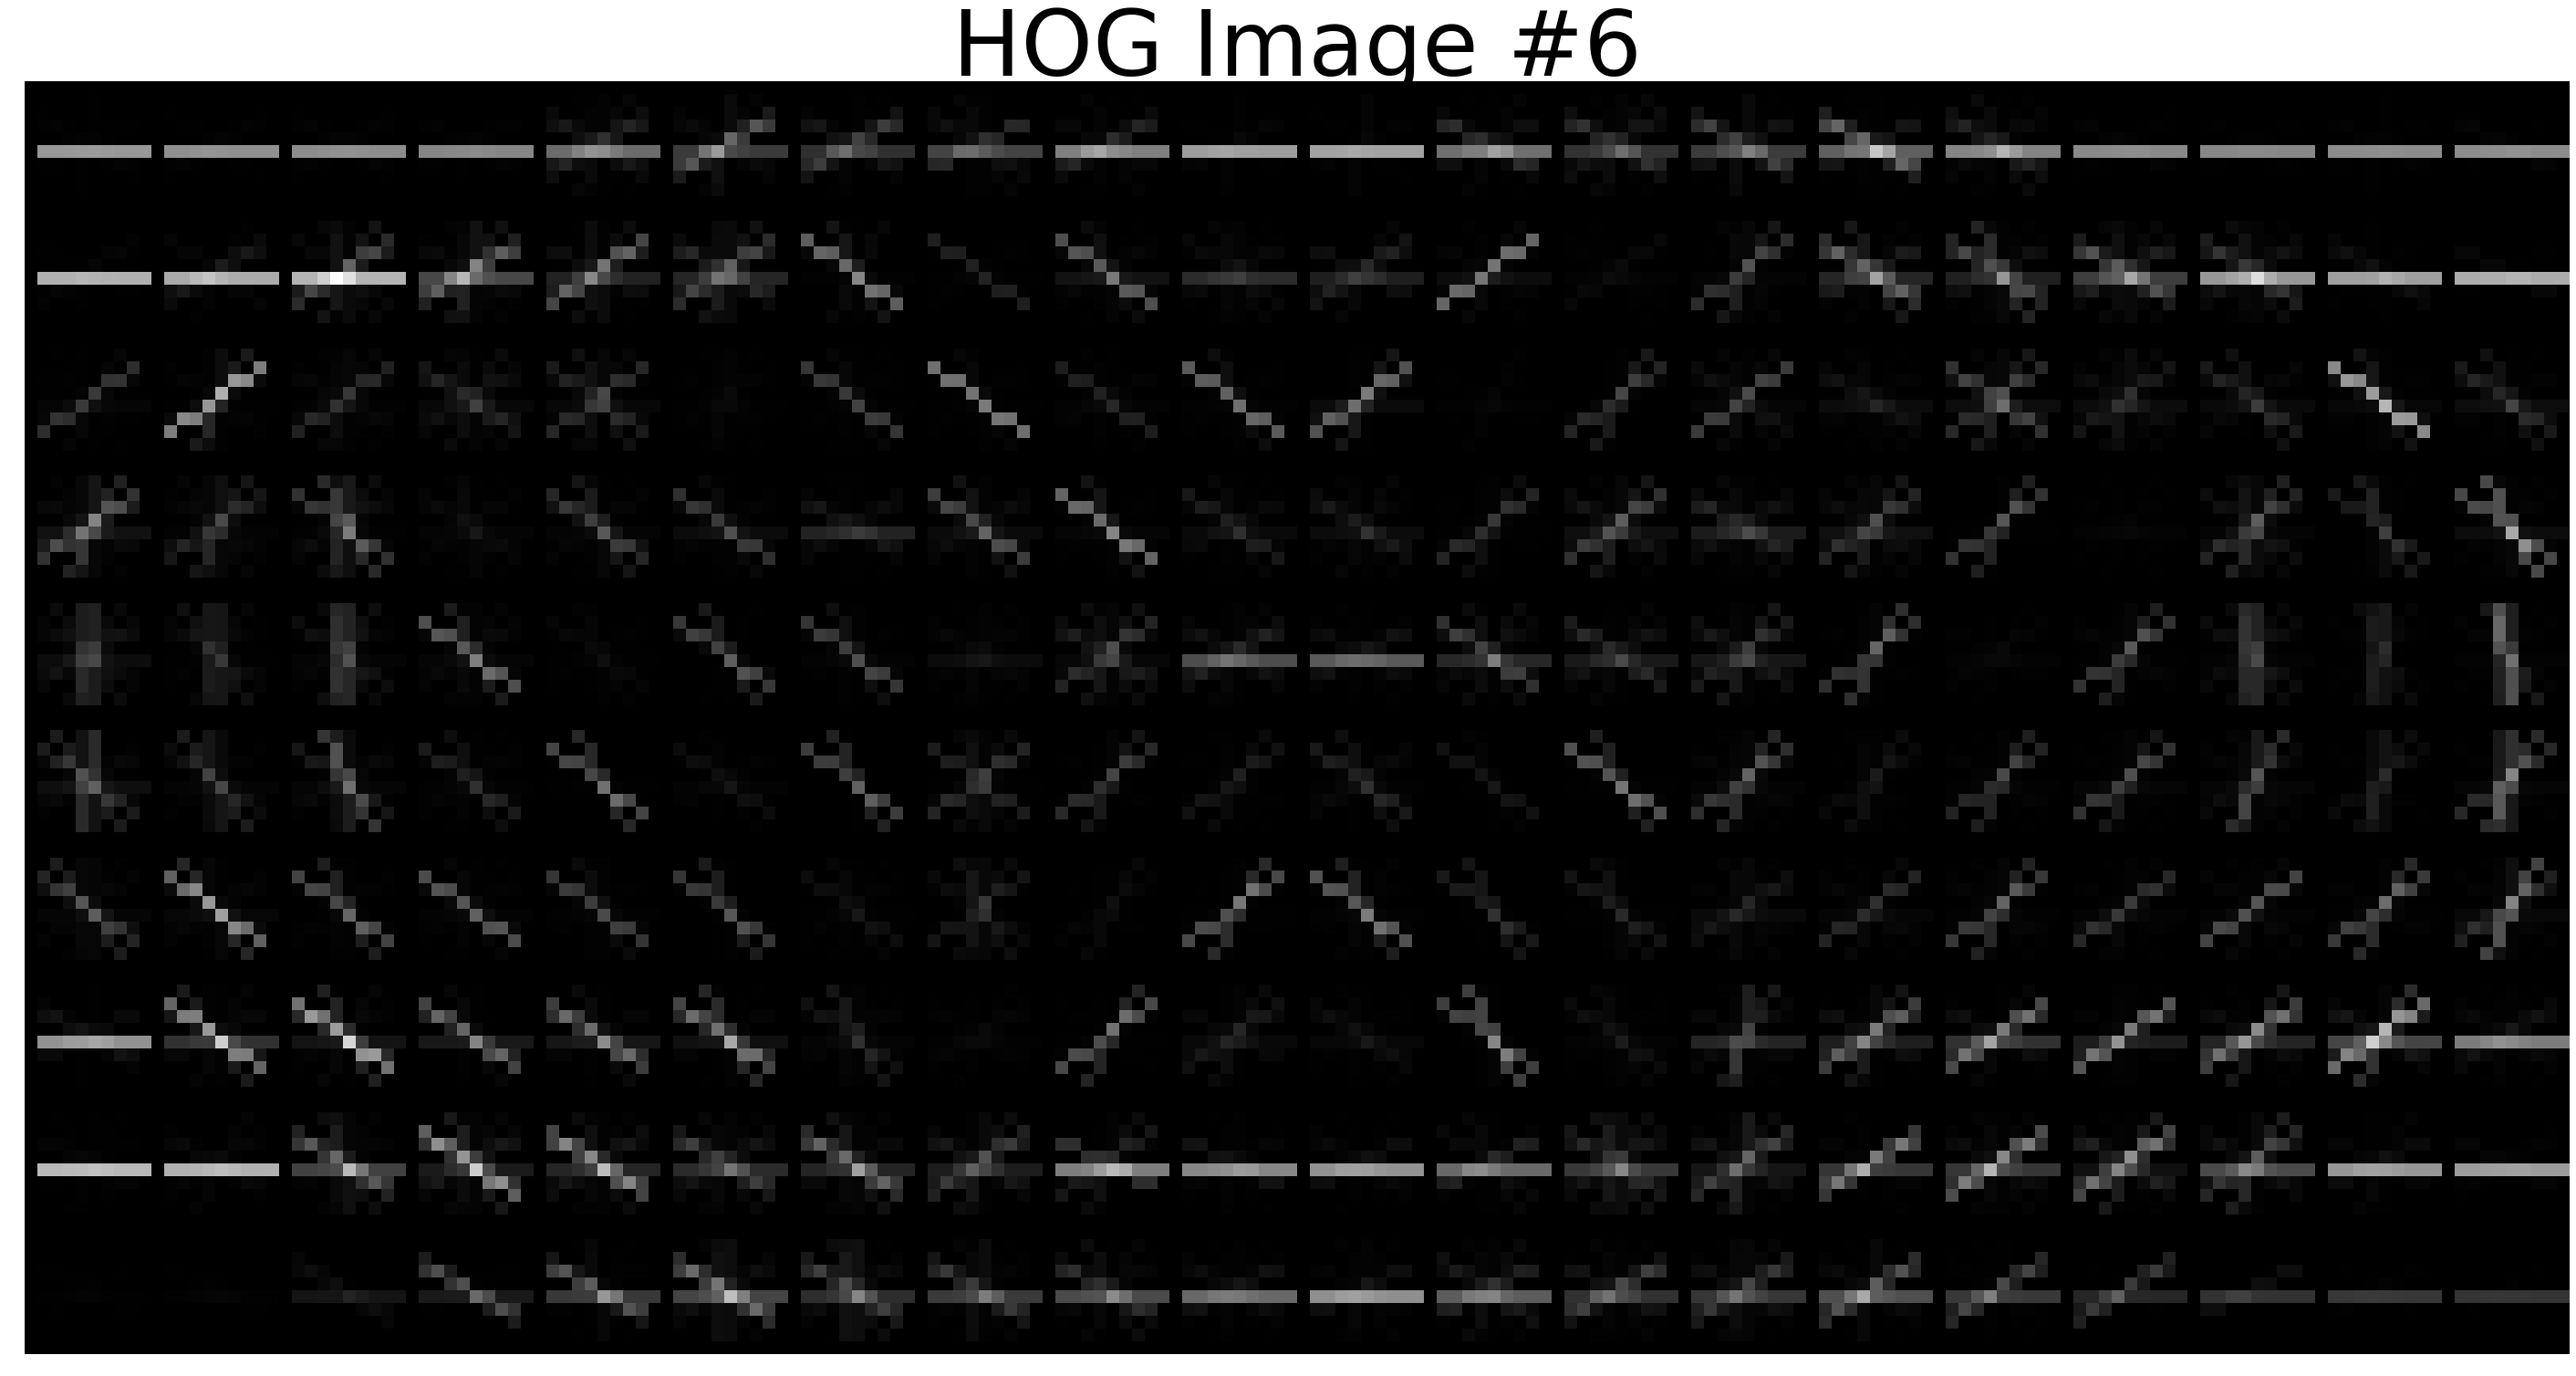

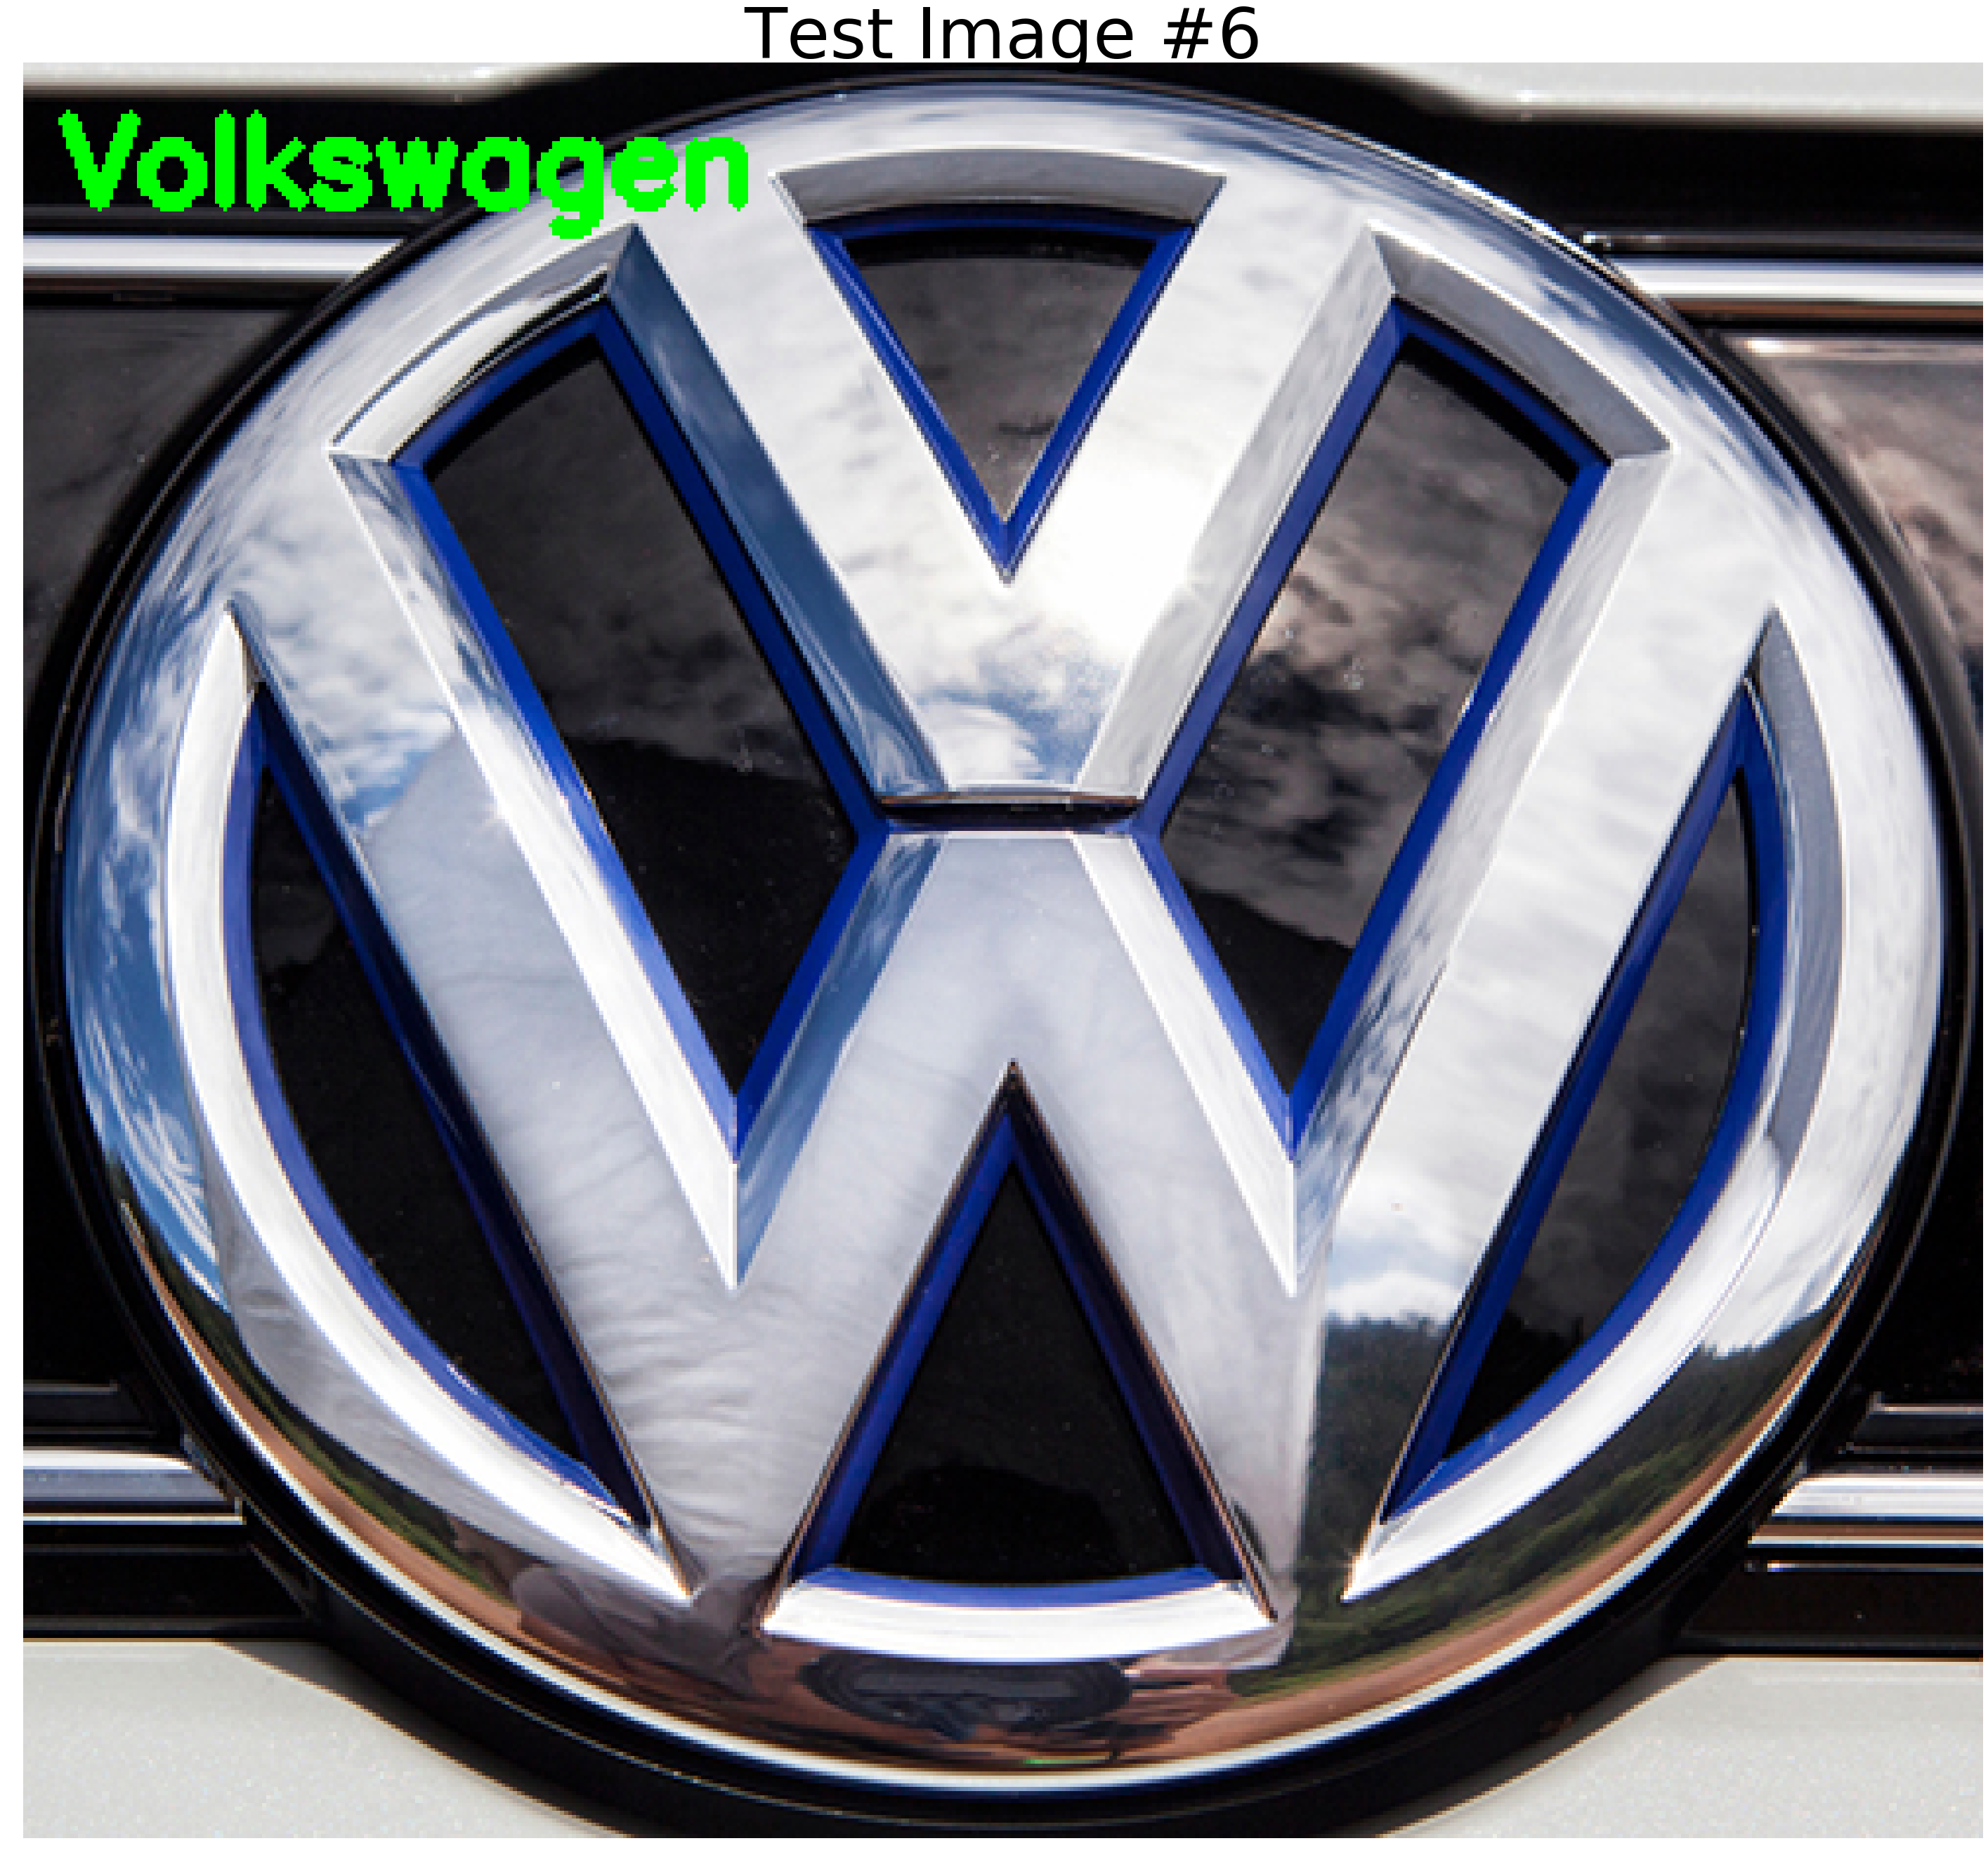

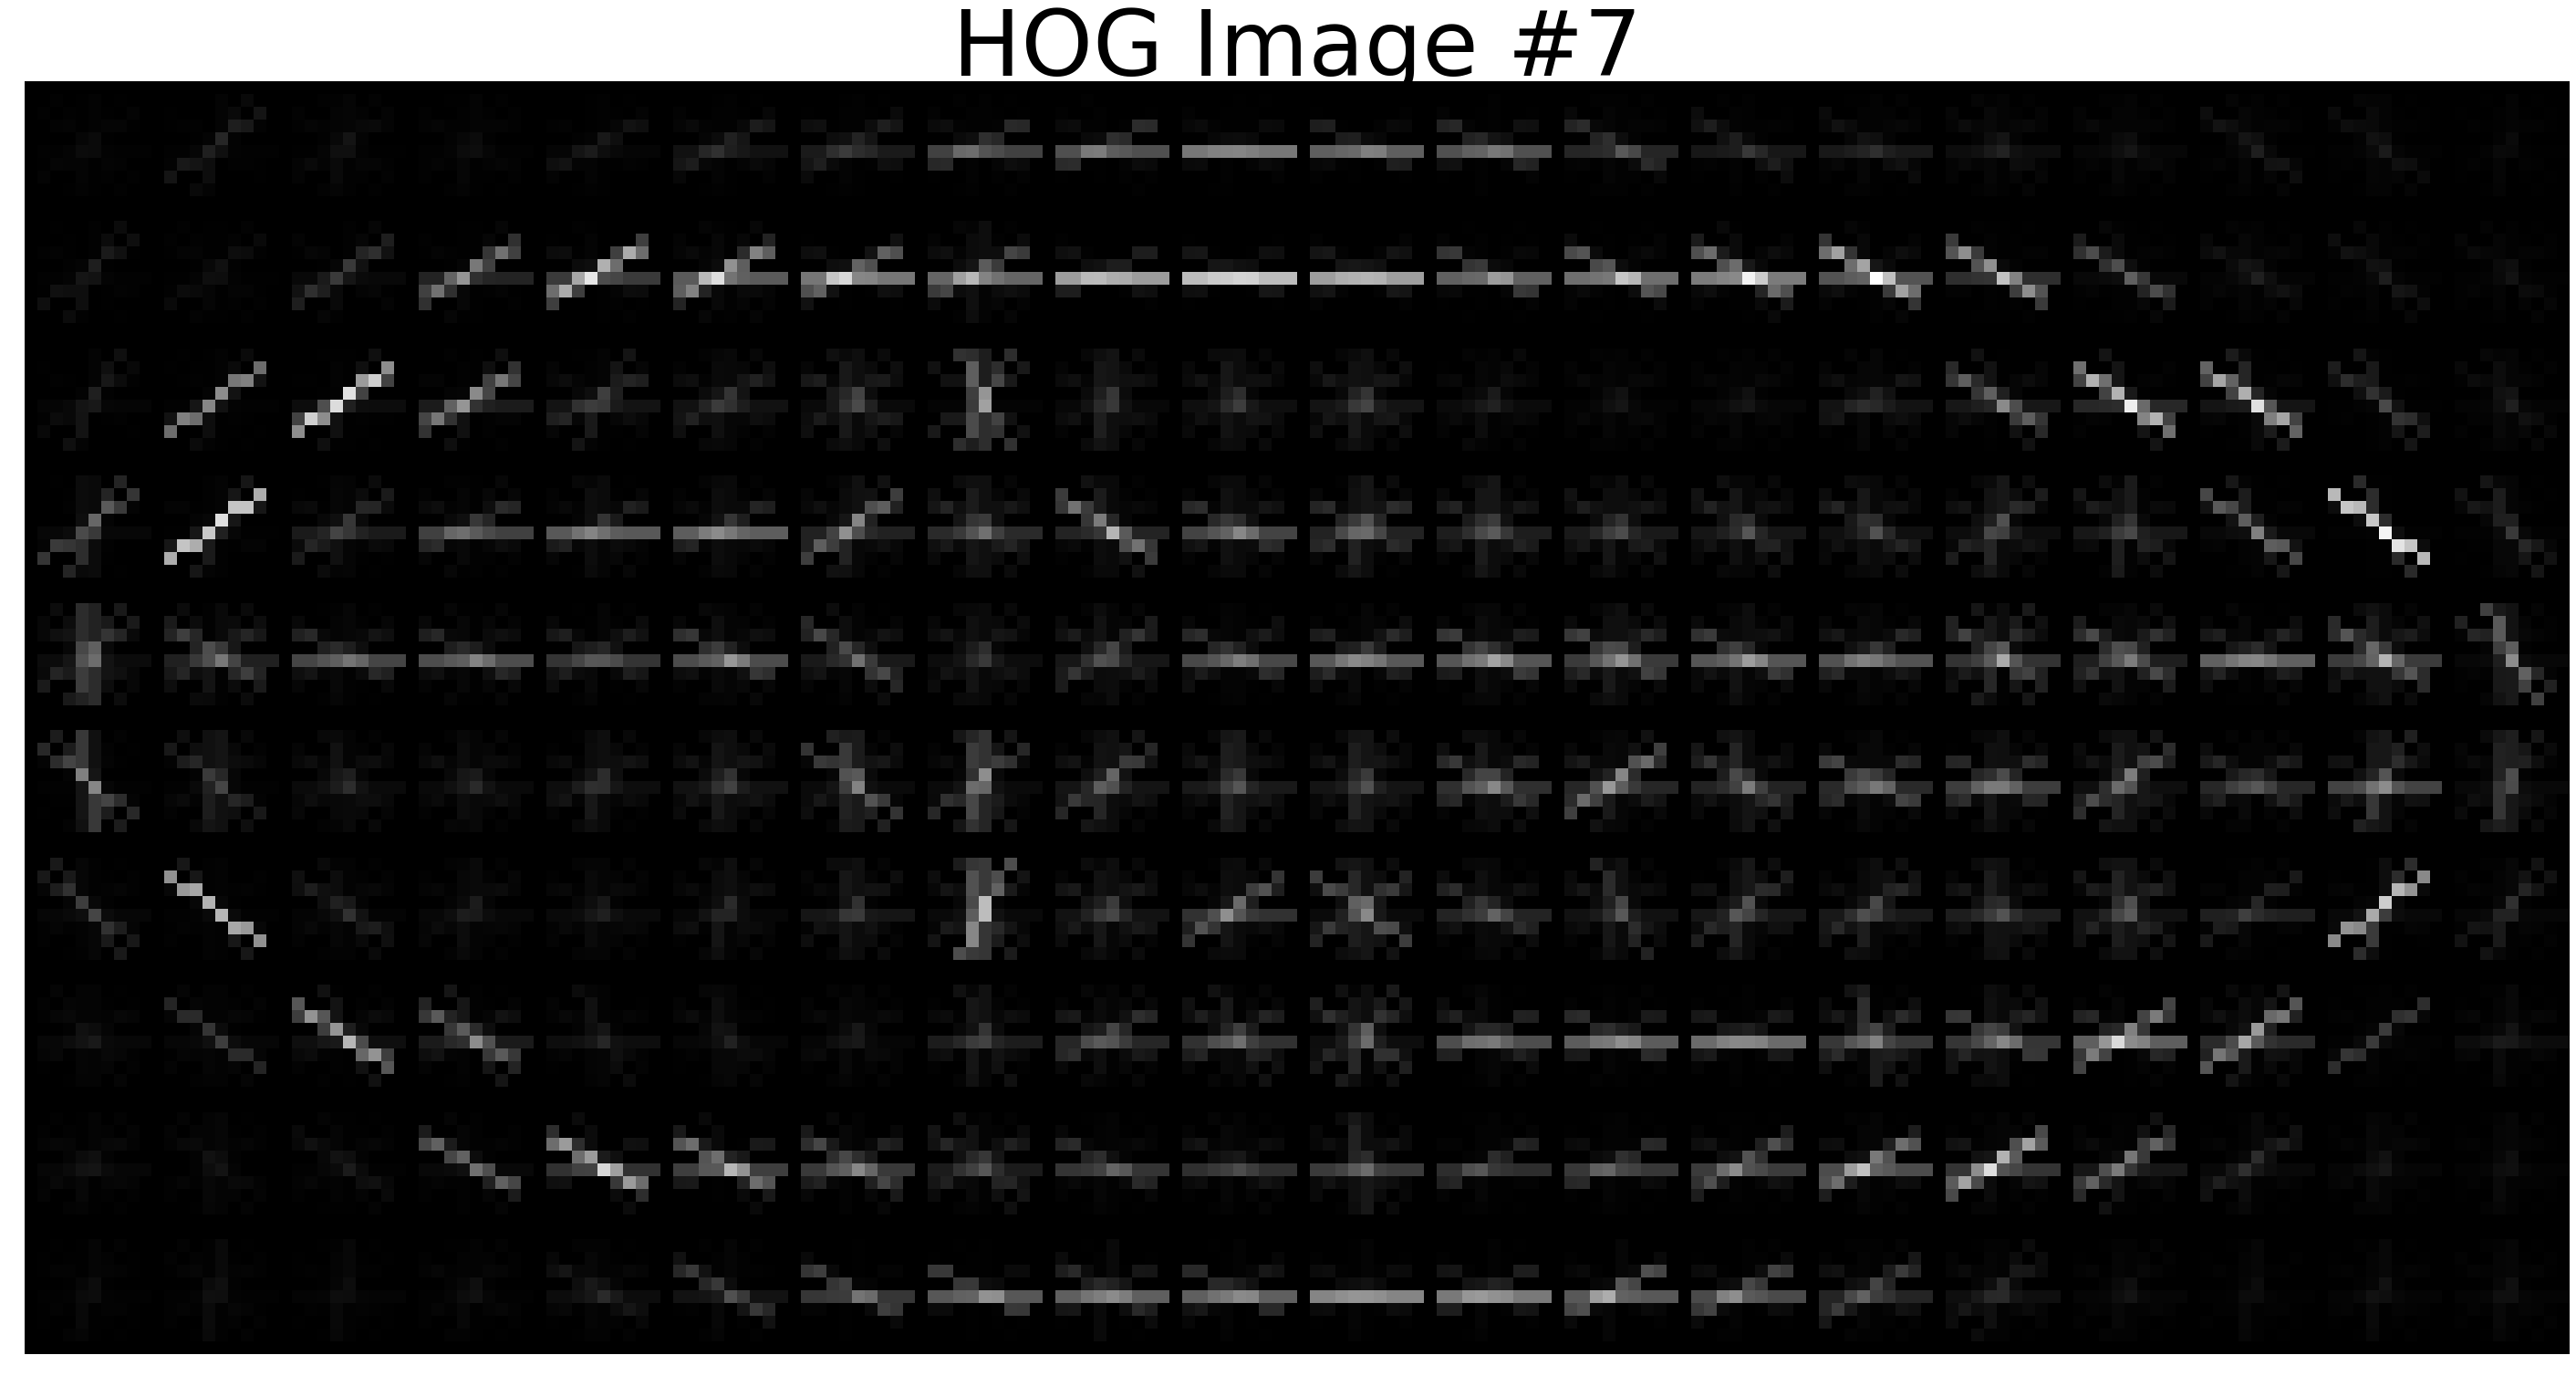

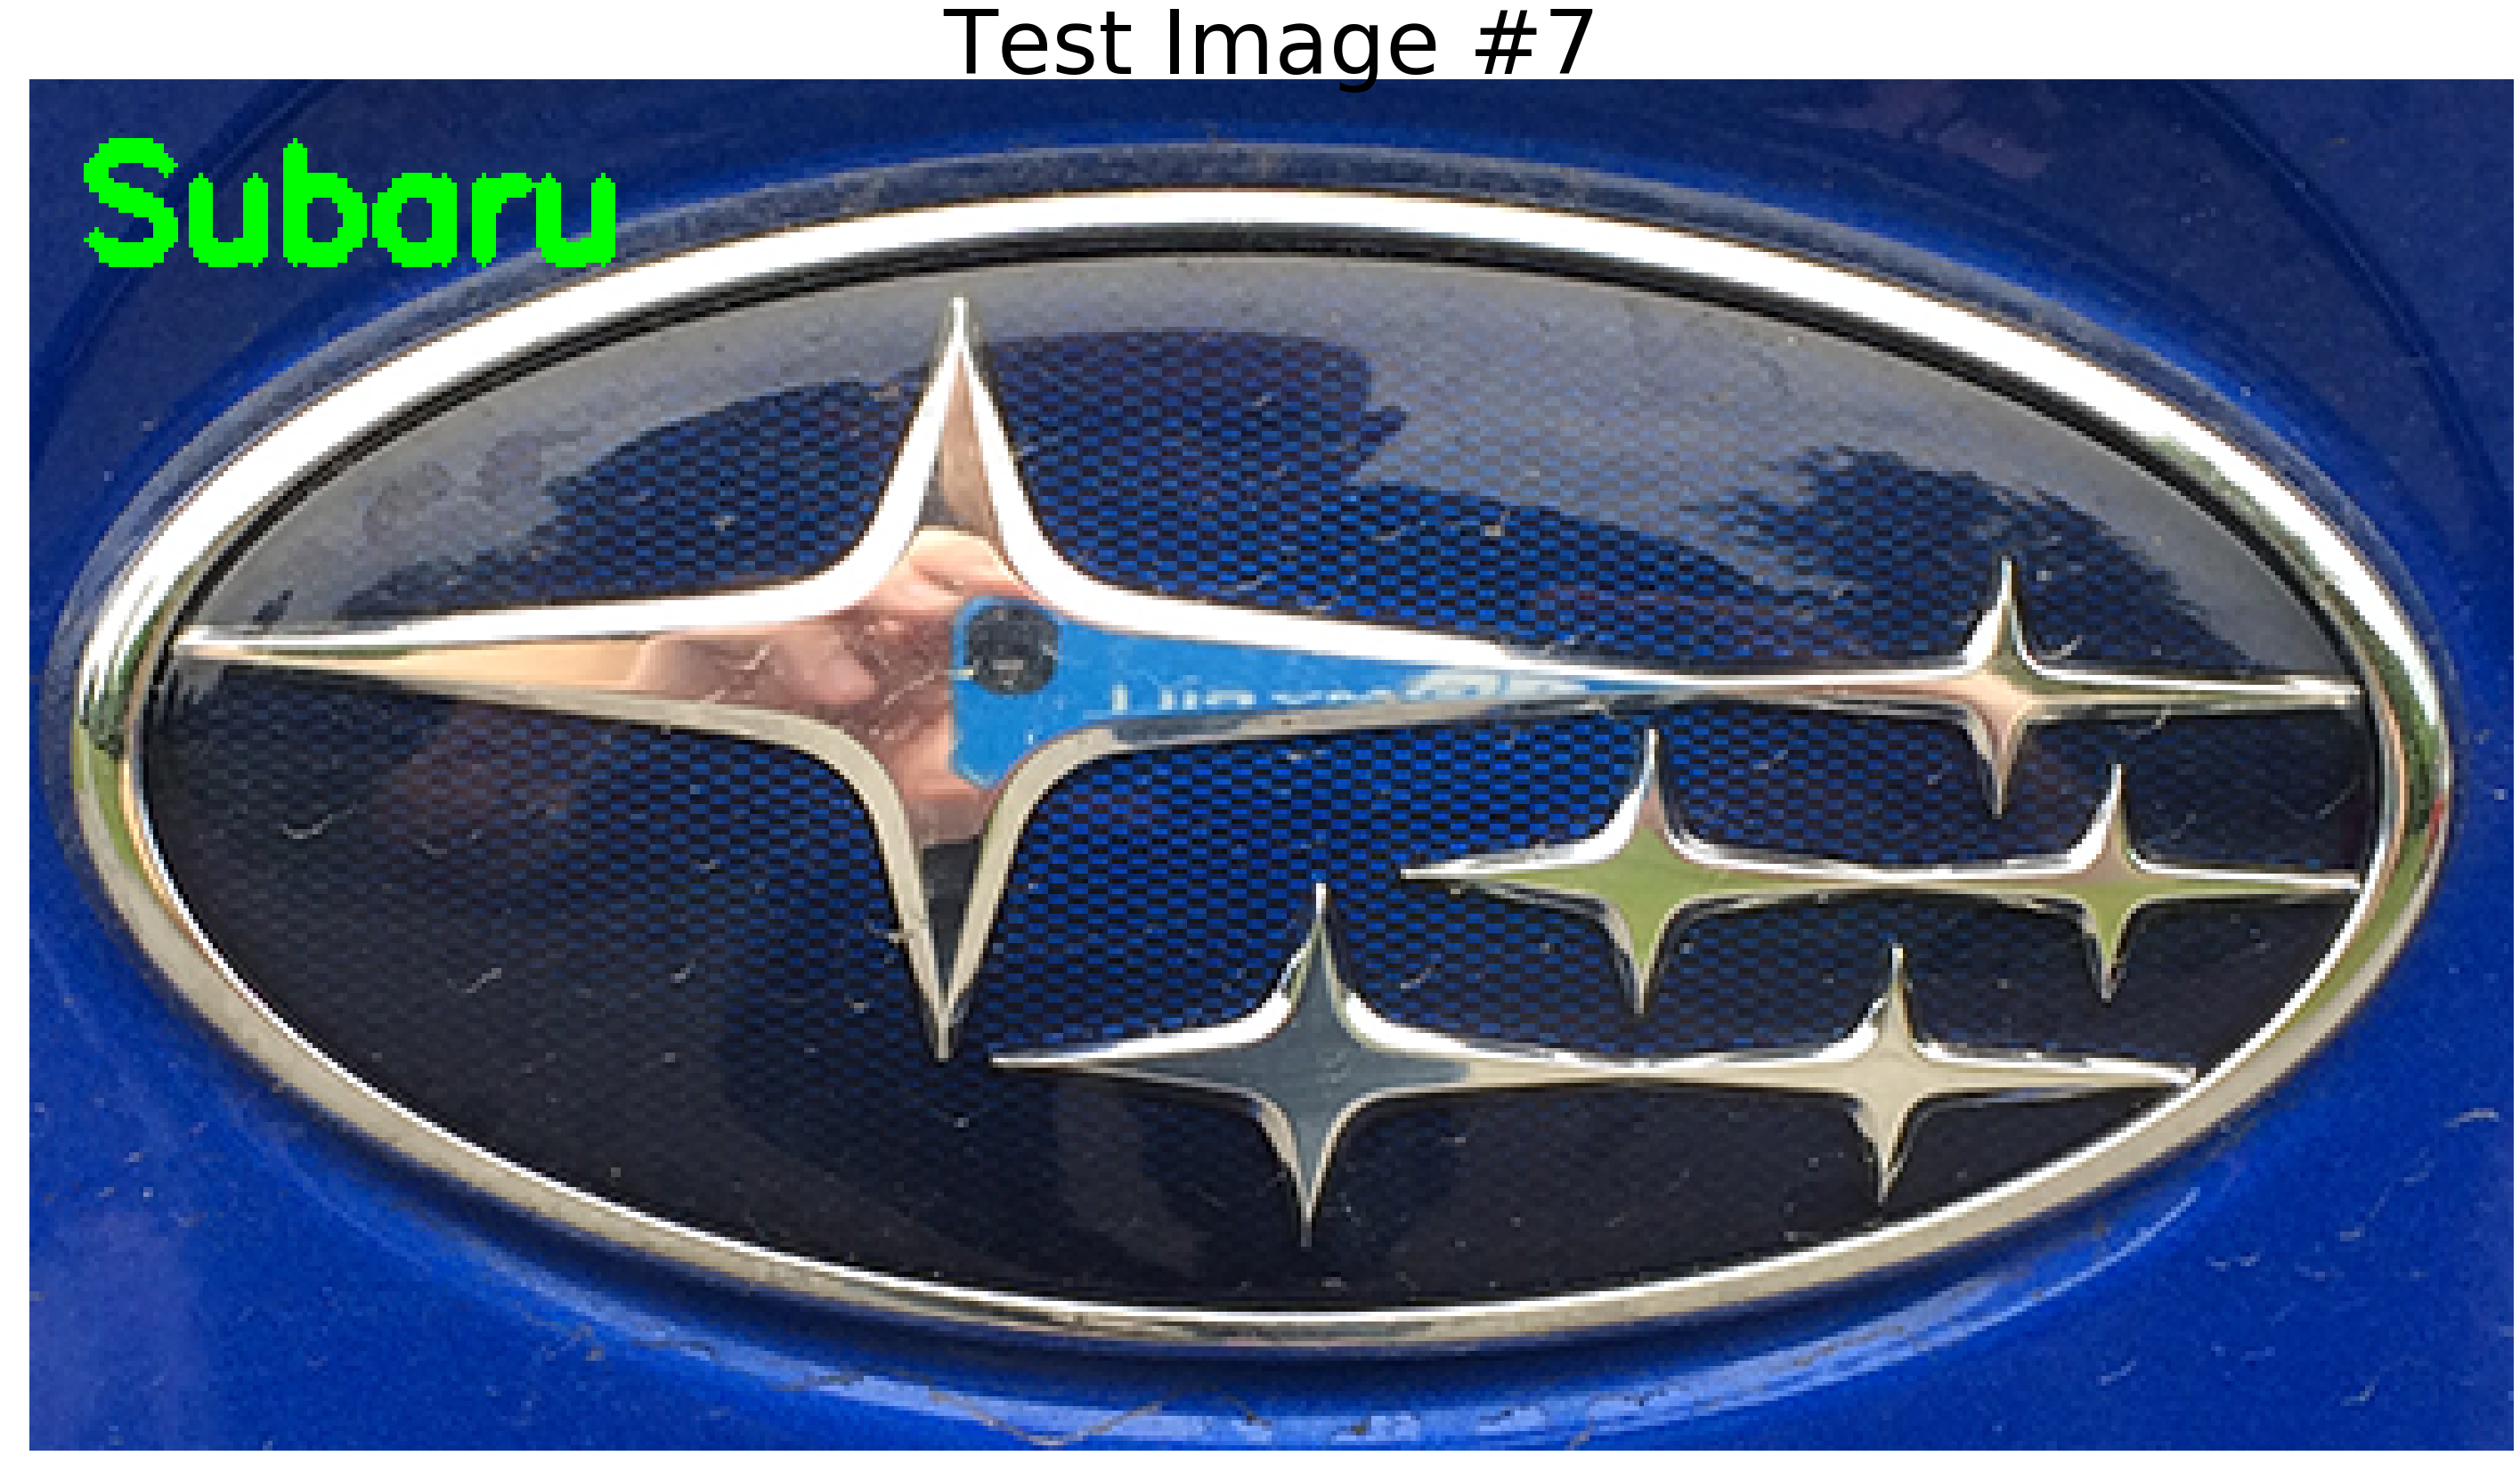

In [5]:
# Loop no dataset de teste
for (i, imagePath) in enumerate(paths.list_images("imagens/dataset04/test_images")):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    logo = cv2.resize(gray, (200, 100))

    # Extrai o Histograma de Gradientes Orientados da imagem de teste e prevê a marca do carro
    (H, hogImage) = feature.hog(
        logo,
        orientations=9,
        pixels_per_cell=(10, 10),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        visualize=True
    )
    pred = model.predict(H.reshape(1, -1))[0]

    # Visualiza a imagem HOG
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")
    show(hogImage, "HOG Image #{}".format(i + 1))

    # Print das previsões
    cv2.putText(image, pred.title(), (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 3)
    show(image, "Test Image #{}".format(i + 1))